# A statistical Conllu file Exploration of  Universal Dependencies

## Introduction

While much work is being done in the current days on NLP and NLU, there is little work on describing why a certain length of transformer (or other as LSTM time steps) architecture has been chosen for the training, it is mostly arbitrary and depends on the goal of the work and resources available (mainly hardware). These decisions are hard once the model has been trained and there is nothing that can be done to extend the length of a transformer (for example) without having to retrain the entire network. There are however some works that tackle variable length sequences. 

This work presents a first complete analysis of the Universal Dependencies v2.6 dataset and presents the globan and individual results of each language present in the dataset.

This work does not intend to be a conference level paper (that is why there are no references to all the papers on each subject), but an informational technical report that might help to better select the most effective compromise text or token length for your particular NLP application.

The number of analyzed languages is 92, the token length is measured as the named UPOS tag in the dataset, while the character length is just that. There is no analysis on what constitutes a word or not, this means that a token includes the punctuiation and other symbols presents in the text samples. For lingüstic analysis purposes more de




## Observations

The histograms show a skew on the distribution, this can be a skewed gaussian, a generalized gaussian or a beta distribution form.

While doing this work I found quite interesting that are languages whose number of tokens or characters avoid certain bins in the histogram (Bulgarian, Breton Welsh, Danish, Slovak, Tamil and Thai are a few examples of this). This can mean that, either the language structure supports only those lengths, or that the analyzed dataset only contains samples that avoid some sentence lengths.

For some languages the number of samples is too small to make any good assumption from the data.


## Conclusion

This work presents a sample length analysis by language on the UniversalDependencies v2.6 dataset presenting the statistics for all 92 represented languages. The analysis then shows the length histograms by character and token length.

The best compromise for choosing a sequence length on the NLP architecture for training will depend mostly on the requirements of the applicatino, nevertheless with the numbers here you should be able to make an informed guess on what might be better for your case.

We can see that having a multi-lingual approach will necessary make the needed sequences longer as there is a large variability on sequence length, but appliying to single language might allow you to optimize your neural architectures

## Future Work

I am currently working on a more in depth analysis of the complete Gutenberg project dataset ( ~60K books in several languages) that will discriminate several other text characteristics.

I also have started to work on a complete parsing of a few of the Wiktionary datasets.

Stay tuned for those results ;)

In [1]:
from multiprocessing import Pool, cpu_count

import math
import os, sys
import orjson as json
import pyconll
import pyconll.util
from pycountry import languages

try:
    from utf8.utils import *
except:
    # to solve issue with ipython executing this import
    from utils import *

from preprocessors.preprocess_conllu import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [27]:
# UD_VERSION = "2.6"
# BASEPATH = "/home/leo/projects/Datasets/text"
# CONLLU_BASEPATH = os.path.join(BASEPATH, 'UniversalDependencies/ud-treebanks-v{}'.format(UD_VERSION))
CONLLU_BASEPATH = "/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.6"

In [28]:
rootdir=CONLLU_BASEPATH
blacklist=[]  # BLACKLIST
allconll = get_all_files_recurse(rootdir)
train, test, dev = filter_conllu_files(allconll, blacklist)

In [29]:
def conllu_get_fields(fname):
    """
    Processes one conllu file
    :param fname: absolute path to the conllu file
    :return:
    """
    conll = pyconll.load_from_file(fname)
    upos = []
    xpos = []
    deprel = []
    sentences = []
    forms = []

    src_lang = path_leaf(fname).split('_')[0]
    for sen in conll:
        sentences.append((src_lang, sen.text))
        try:
            forms.extend([t.form for t in sen._tokens])
        except:
            pass
        try:
            sen_upos = [t.upos for t in sen._tokens]
            upos.append((src_lang, sen.text, tuple(sen_upos)))
        except:
            pass
        try:
            sen_xpos = [t.xpos for t in sen._tokens]
            xpos.append((src_lang, sen.text, tuple(sen_xpos)))
        except:
            pass
        try:
            sen_deprel = [t.deprel for t in sen._tokens]
            deprel.append((src_lang, sen.text, tuple(sen_deprel)))
        except:
            pass
    
    return (set(upos), len(upos)), (set(xpos), len(xpos)), (set(deprel), len(deprel)), (set(sentences), len(sentences)), (set(forms), len(forms))


In [30]:
def _try_get_2list(fname):
    try:
        return conllu_get_fields(fname)
    except Exception as e:
        print("Error processing file: {} \nWith error: {}".format(fname, e))


def conllu_process_get_2list(rootdir=CONLLU_BASEPATH, blacklist=BLACKLIST):
    allconll = get_all_files_recurse(rootdir)
    train, test, dev = filter_conllu_files(allconll, blacklist)
    all_files = train + test + dev
#     print(all_files)

    with Pool(processes=cpu_count()) as pool:
        res = pool.map(_try_get_2list, all_files)
        return res


In [31]:
%%time
res = conllu_process_get_2list(blacklist=[])

['/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.6/UD_Basque-BDT/eu_bdt-ud-train.conllu', '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.6/UD_Danish-DDT/da_ddt-ud-train.conllu', '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.6/UD_Galician-TreeGal/gl_treegal-ud-train.conllu', '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.6/UD_English-GUMReddit/en_gumreddit-ud-train.conllu', '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.6/UD_Maltese-MUDT/mt_mudt-ud-train.conllu', '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.6/UD_Irish-IDT/ga_idt-ud-train.conllu', '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.6/UD_Galician-CTG/gl_ctg-ud-train.conllu', '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.6/UD_Hindi_English-HIENCS/qhe_hiencs-ud-train.conllu', '/home/leo/projects/Datasets/text/UniversalDependencie

Finding now the shortest and longest sequences, checking the length and plotting those to see what's happening with the dataset.

In [32]:
%%time

upos_data = []
xpos_data = []
deprel_data = []
sentences_data = []
forms_data = []

for r in res:
    upos_val, xpos_val, deprel_val, sentences_val, forms_val = r
#     print("lala 1")
    forms_data.extend(forms_val[0])
    for val in upos_val[0]:
#         print(val)
        lang1, txt1, upos  = val
        upos_data.append((lang1, txt1, upos, len(upos)))
    for lang2, txt2, xpos in xpos_val[0]:
        xpos_data.append((lang2, txt2, xpos, len(xpos)))
    for lang3, txt3, deprel in deprel_val[0]:
        deprel_data.append((lang3, txt3, deprel, len(deprel)))
    for lang4, txt4 in sentences_val[0]:
        sentences_data.append((lang4, txt4, len(txt4)))

# upos_data = sorted(upos_data)
# xpos_data = sorted(xpos_data)
# deprel_data = sorted(deprel_data)

    

CPU times: user 2.61 s, sys: 138 ms, total: 2.75 s
Wall time: 2.77 s


In [33]:
df_upos = pd.DataFrame(upos_data, columns=["lang", "text", "upos", "upos_len"])
df_xpos = pd.DataFrame(xpos_data, columns=["lang", "text", "xpos", "xpos_len"])
df_deprel = pd.DataFrame(deprel_data, columns=["lang", "text", "deprel", "deprel_len"])
df_txt = pd.DataFrame(sentences_data, columns=["lang", "text", "text_len"])

In [34]:
df_upos.columns

Index(['lang', 'text', 'upos', 'upos_len'], dtype='object')

In [35]:
df_upos['lang'].describe()

count     1288375
unique         92
top            de
freq       204276
Name: lang, dtype: object

In [36]:
langs = sorted(df_upos['lang'].unique())

In [52]:
len(langs)

92

## Token (by UPOS) length analysis and histogram plot

In [37]:
df_upos.describe()

,upos_len
count,1.288375e+06
mean,1.873475e+01
std,1.425062e+01
min,1.000000e+00
25%,9.000000e+00
50%,1.600000e+01
75%,2.400000e+01
max,7.140000e+02


In [55]:
frupos = df_upos.loc[df_upos['lang'] == 'fr']['upos_len']

In [ ]:
frupos.describe()

<ipython-input-40-3577753619f9>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Error processing lang qhe with Exception 'NoneType' object has no attribute 'name'


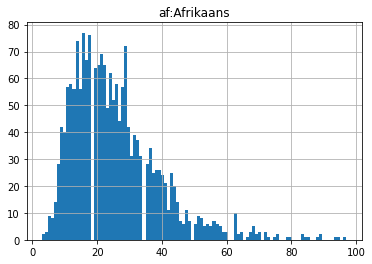

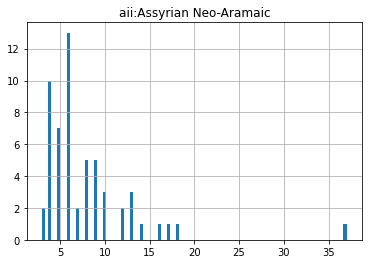

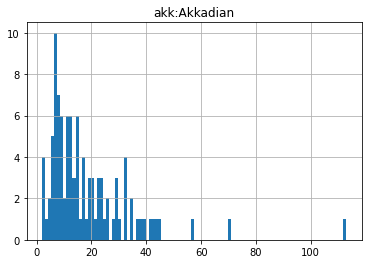

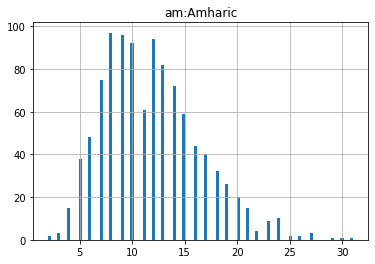

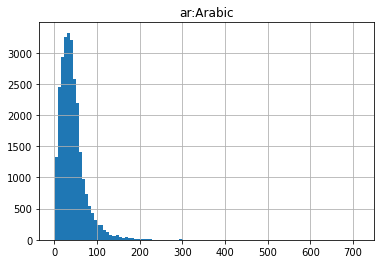

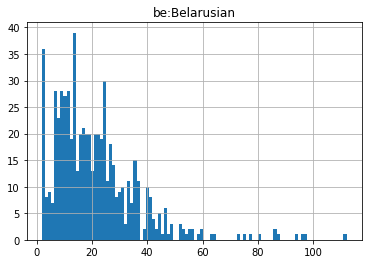

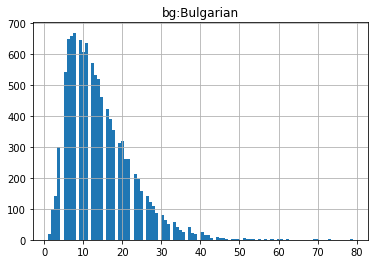

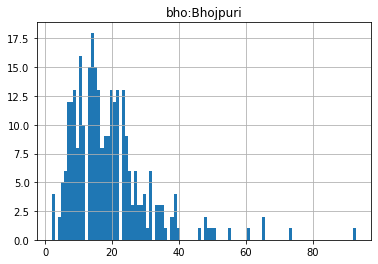

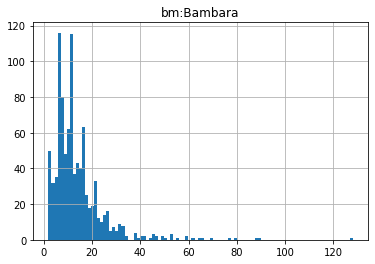

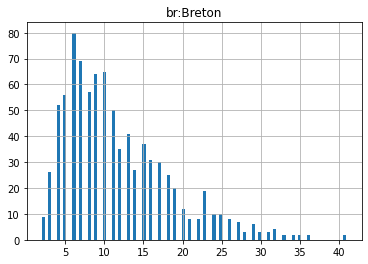

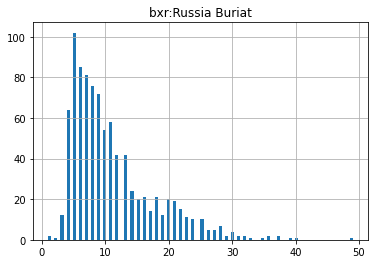

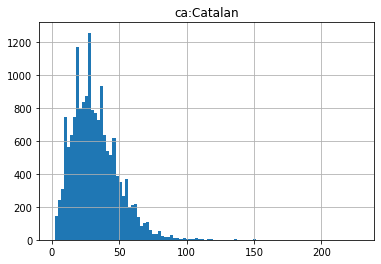

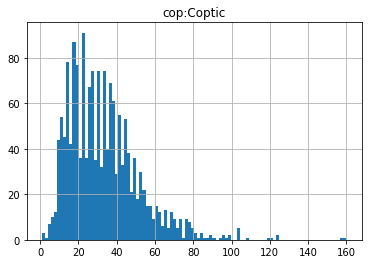

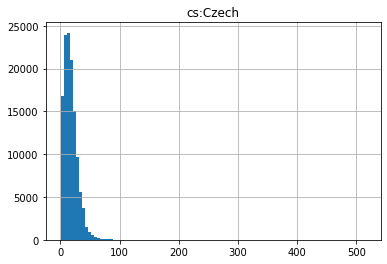

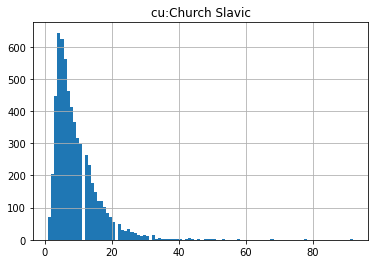

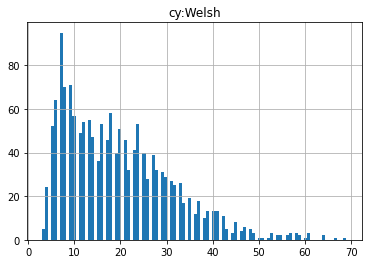

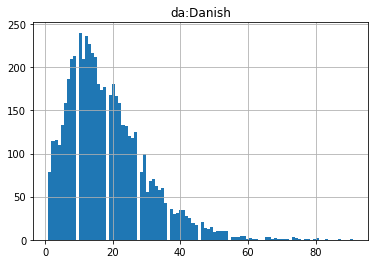

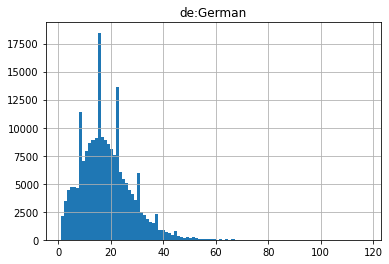

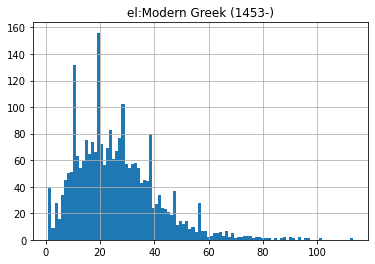

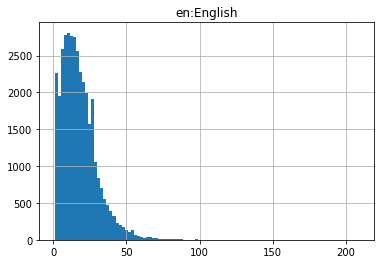

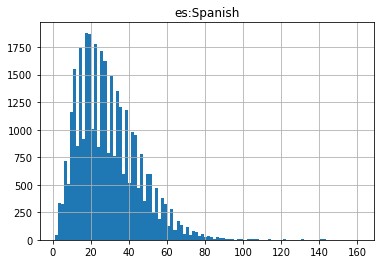

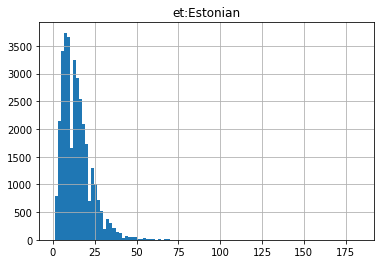

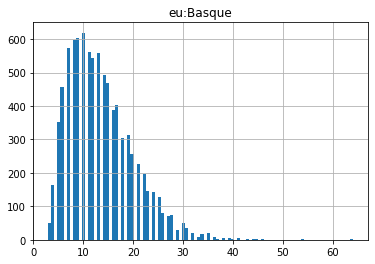

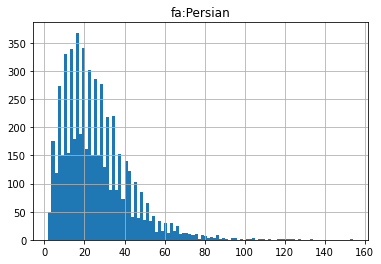

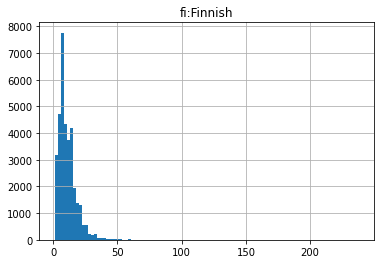

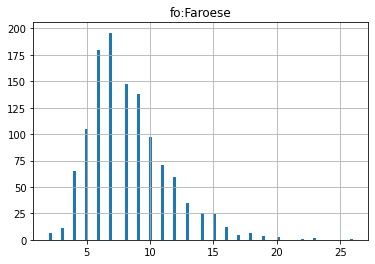

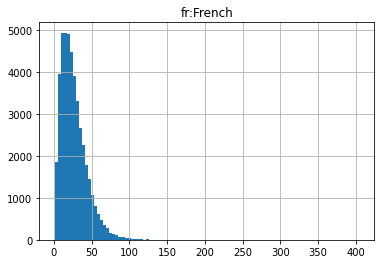

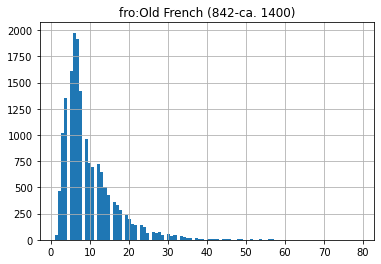

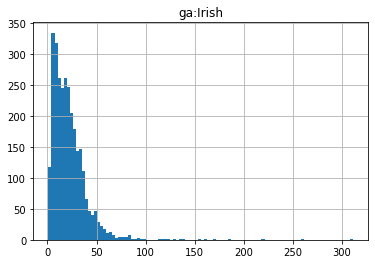

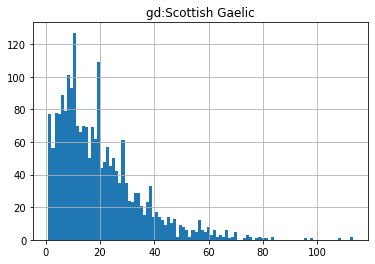

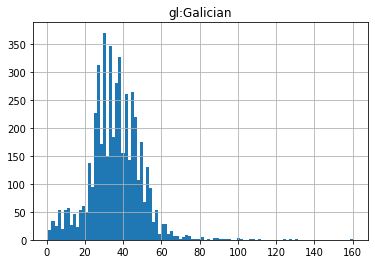

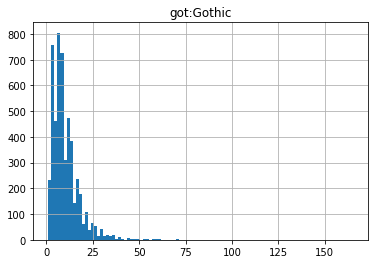

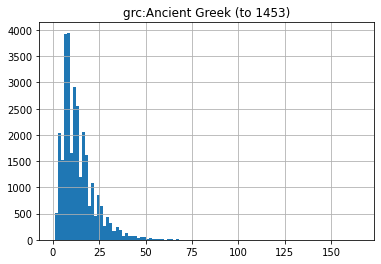

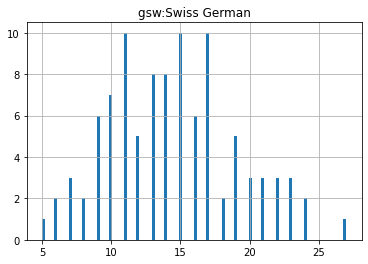

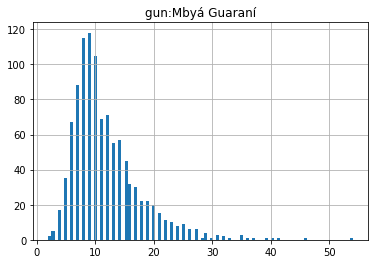

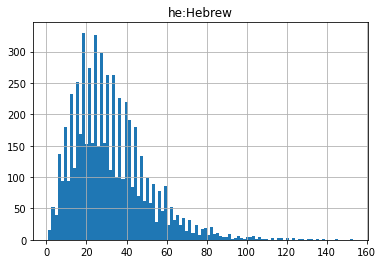

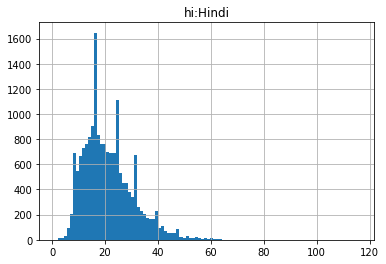

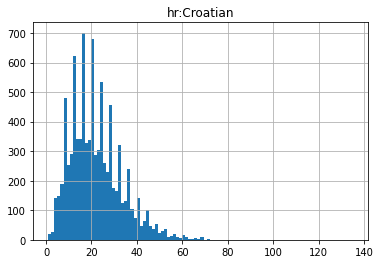

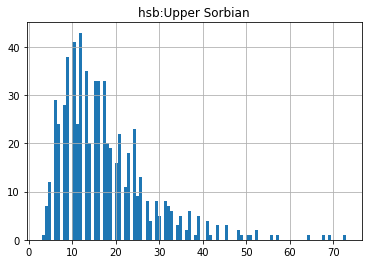

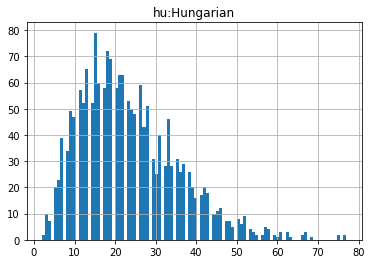

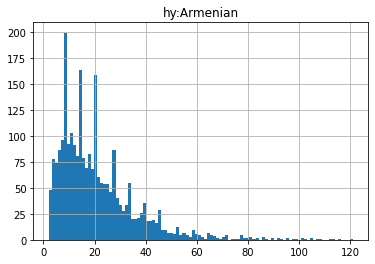

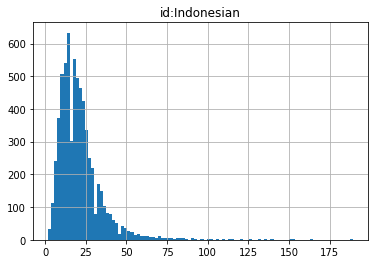

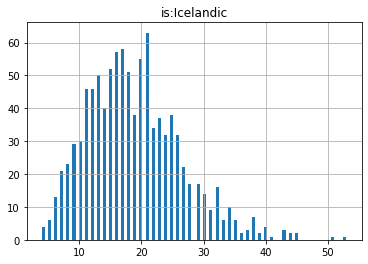

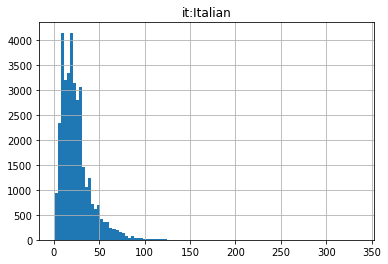

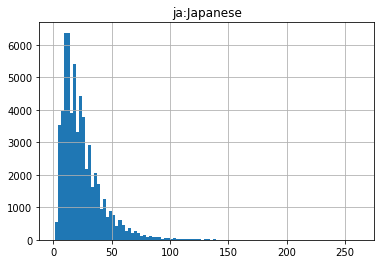

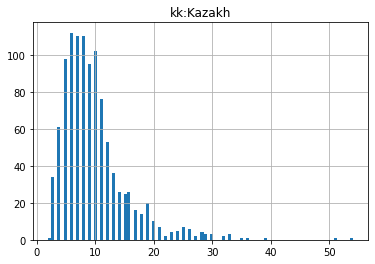

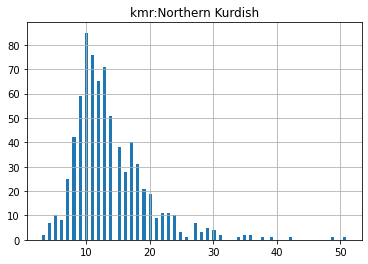

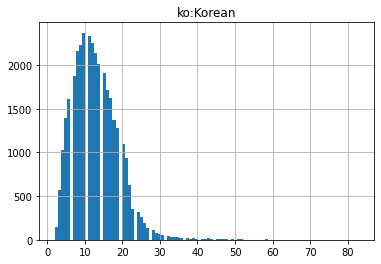

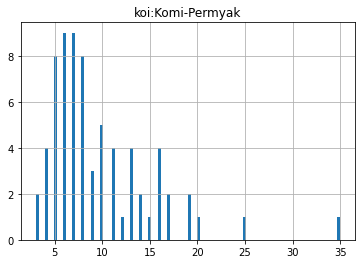

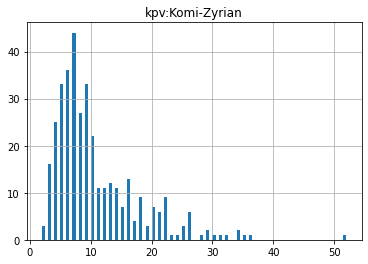

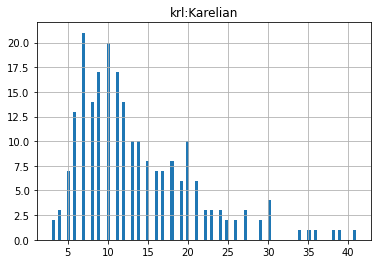

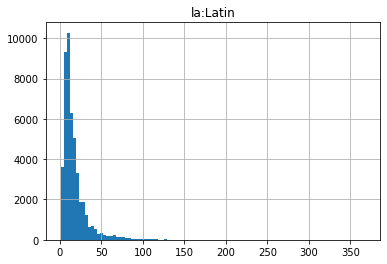

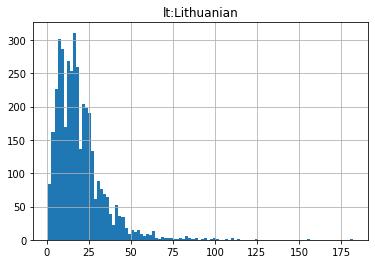

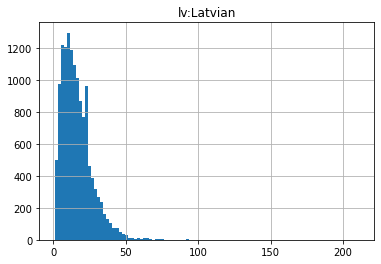

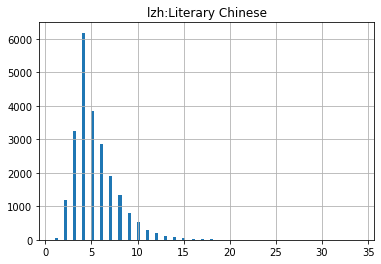

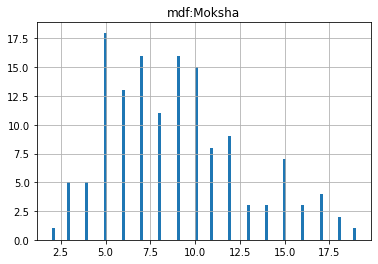

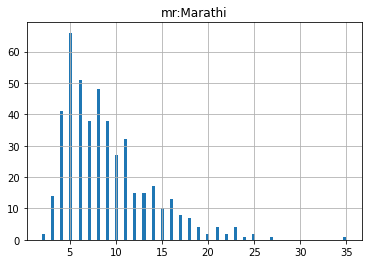

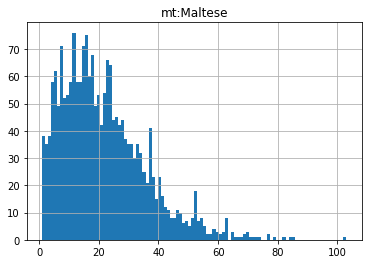

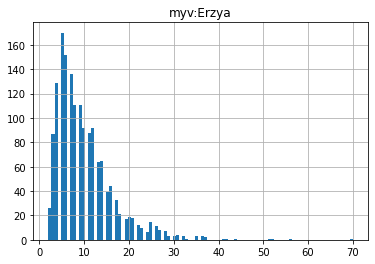

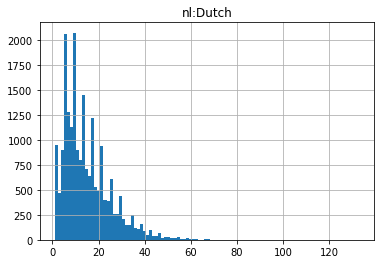

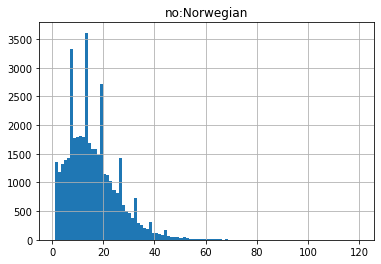

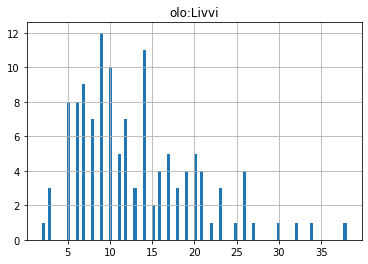

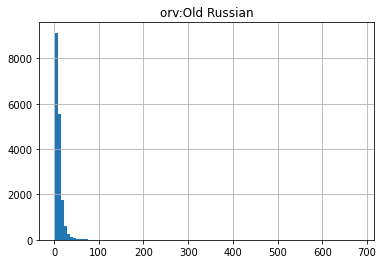

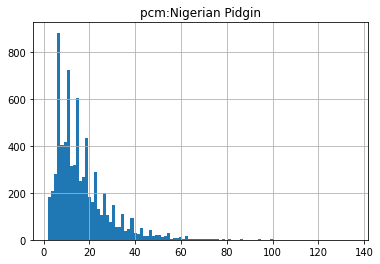

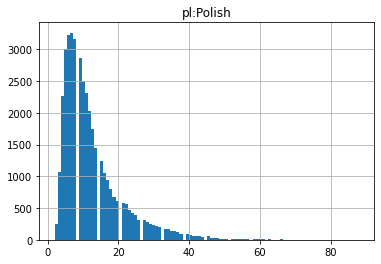

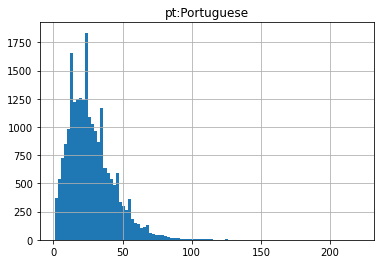

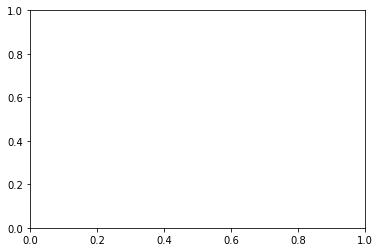

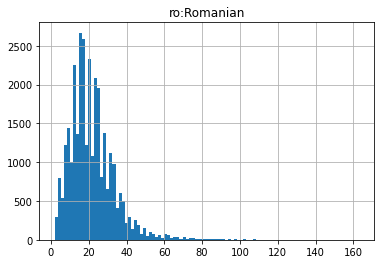

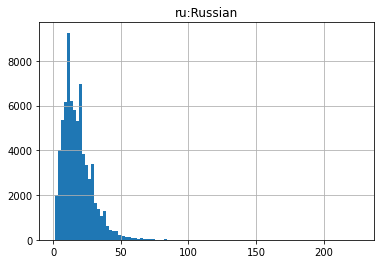

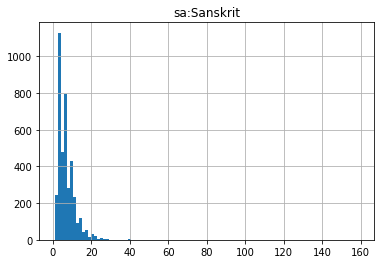

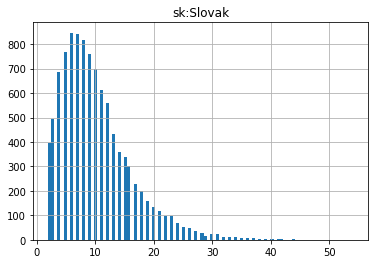

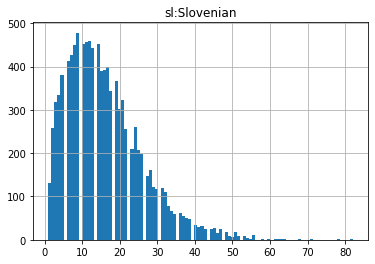

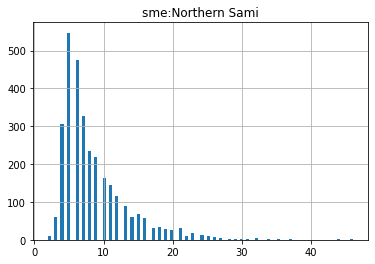

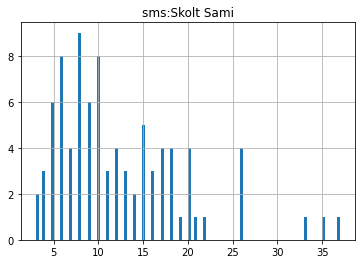

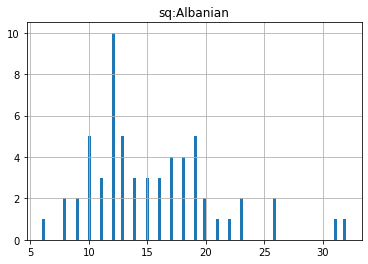

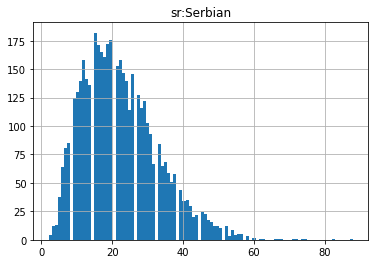

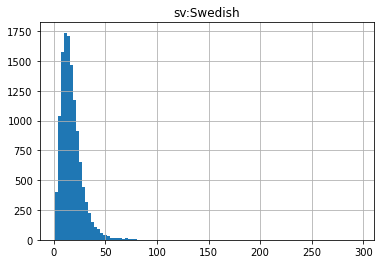

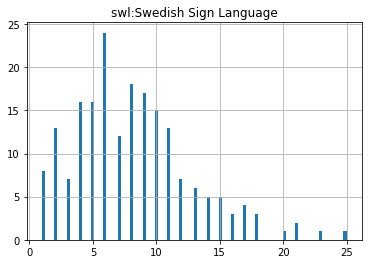

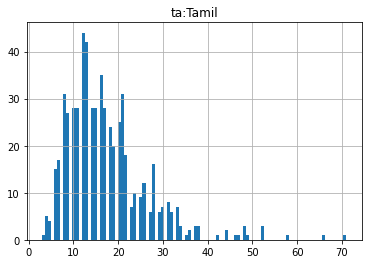

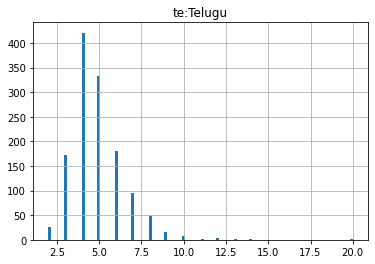

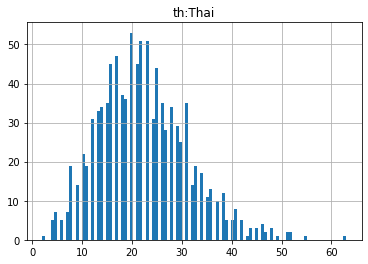

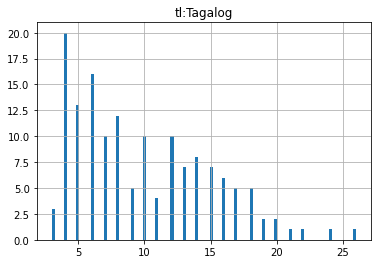

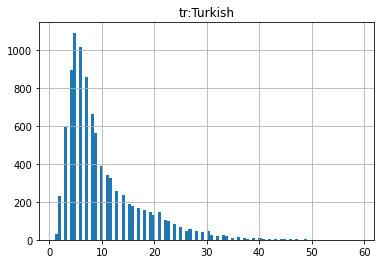

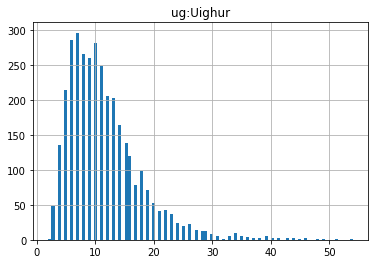

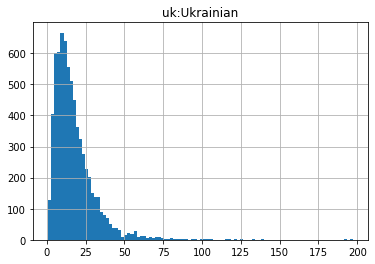

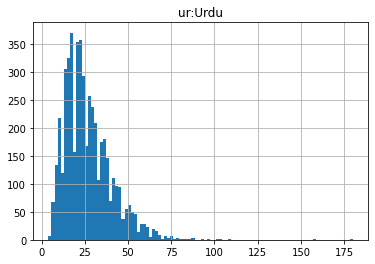

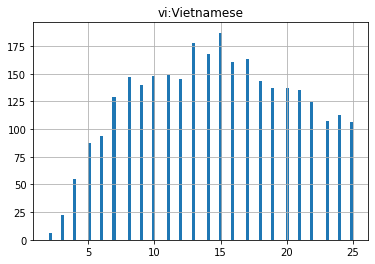

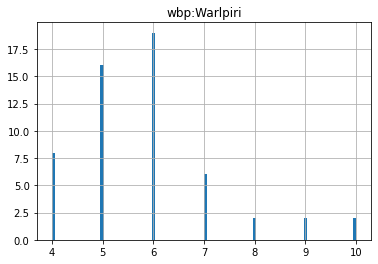

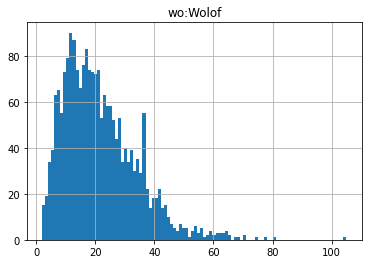

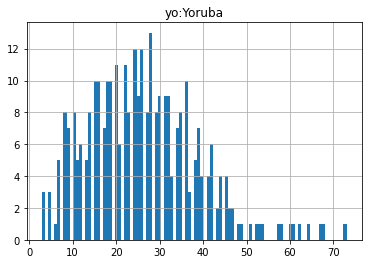

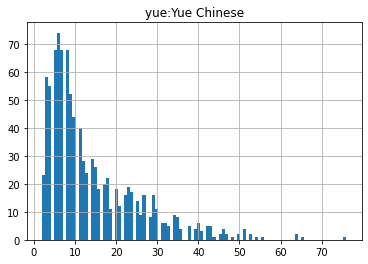

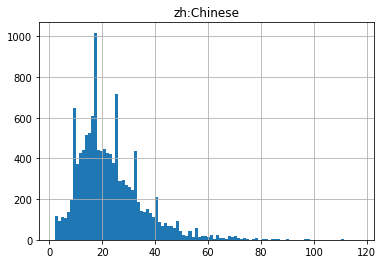

In [40]:
for lang in langs:
    try:
        fig, ax = plt.subplots()
        dest_lang = languages.get(alpha_2=lang) if len(lang) == 2 else languages.get(alpha_3=lang)
        dest_lang = dest_lang.name
        ax.set_title(lang +":" +dest_lang )
        df_upos.loc[df_upos['lang'] == lang]['upos_len'].hist(bins=100, ax=ax, label=lang)
    except Exception as e:
        print("Error processing lang {} with Exception {}".format(lang, e))
        pass

A token is a word or a punctuation mark. Punctuation is counted in the sentence length.

Is interesting to see that most languages have few sentences longer than 100 tokens (including the punctuation)

Also, each language has a different centroid for the sentence length.

Also it's an interesting that different languages show different strip patterns, each having a different interval of lengths that are empty (like basque for example) while the count next to it has high counts (length 10 for basque has a count of more than 600 while the left and right are just empty). 

These patterns are really interesting.



In [41]:
df_deprel.describe()

,deprel_len
count,1.288570e+06
mean,1.874613e+01
std,1.426159e+01
min,1.000000e+00
25%,9.000000e+00
50%,1.600000e+01
75%,2.400000e+01
max,7.140000e+02


In [42]:
langs

['af',
 'aii',
 'akk',
 'am',
 'ar',
 'be',
 'bg',
 'bho',
 'bm',
 'br',
 'bxr',
 'ca',
 'cop',
 'cs',
 'cu',
 'cy',
 'da',
 'de',
 'el',
 'en',
 'es',
 'et',
 'eu',
 'fa',
 'fi',
 'fo',
 'fr',
 'fro',
 'ga',
 'gd',
 'gl',
 'got',
 'grc',
 'gsw',
 'gun',
 'he',
 'hi',
 'hr',
 'hsb',
 'hu',
 'hy',
 'id',
 'is',
 'it',
 'ja',
 'kk',
 'kmr',
 'ko',
 'koi',
 'kpv',
 'krl',
 'la',
 'lt',
 'lv',
 'lzh',
 'mdf',
 'mr',
 'mt',
 'myv',
 'nl',
 'no',
 'olo',
 'orv',
 'pcm',
 'pl',
 'pt',
 'qhe',
 'ro',
 'ru',
 'sa',
 'sk',
 'sl',
 'sme',
 'sms',
 'sq',
 'sr',
 'sv',
 'swl',
 'ta',
 'te',
 'th',
 'tl',
 'tr',
 'ug',
 'uk',
 'ur',
 'vi',
 'wbp',
 'wo',
 'yo',
 'yue',
 'zh']

<ipython-input-44-777f8cd236cc>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Error processing qhe with Exception 'NoneType' object has no attribute 'name'


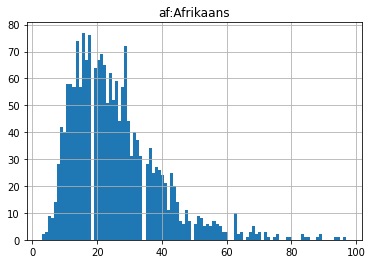

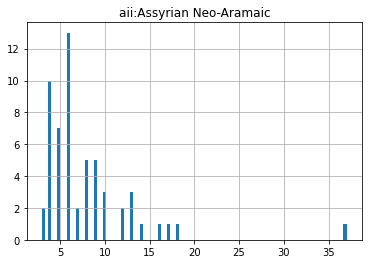

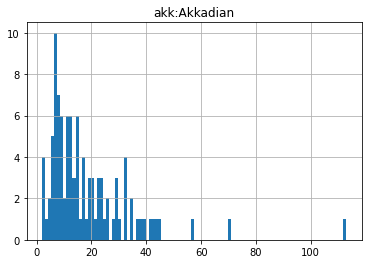

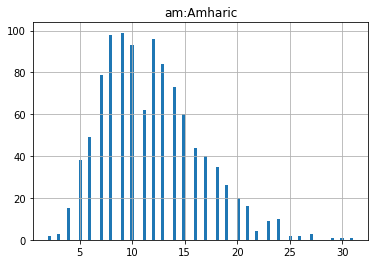

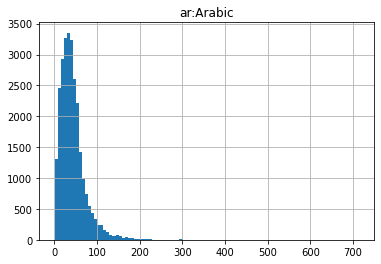

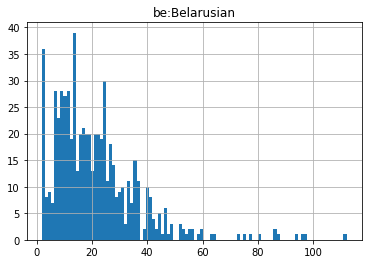

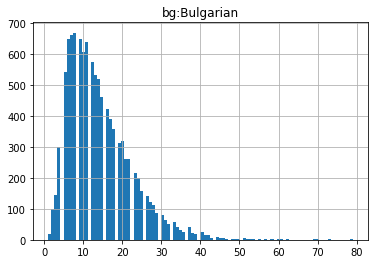

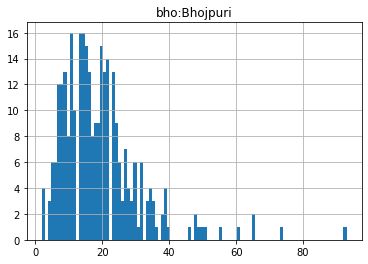

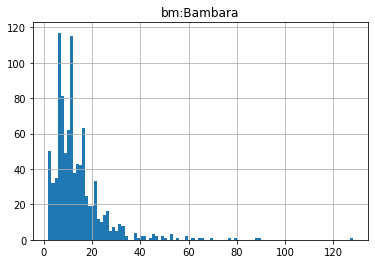

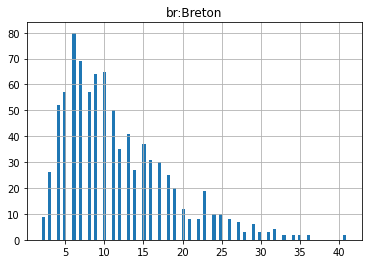

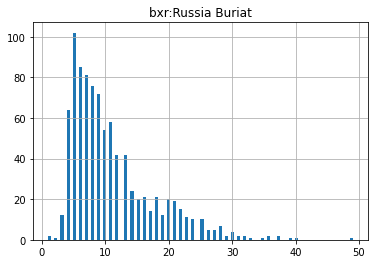

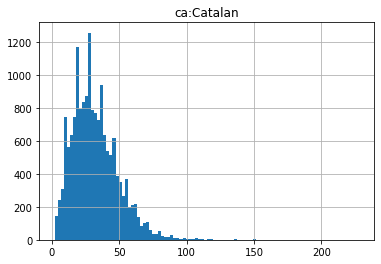

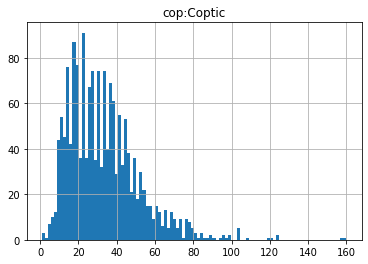

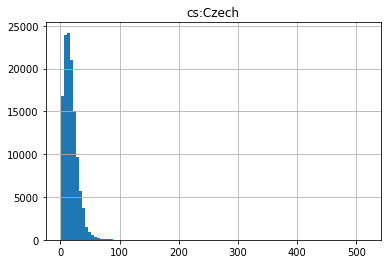

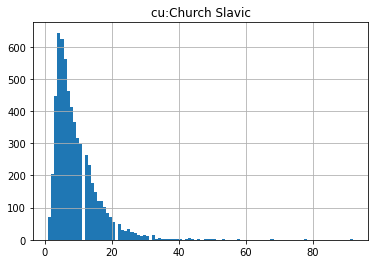

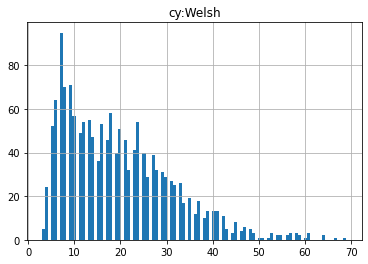

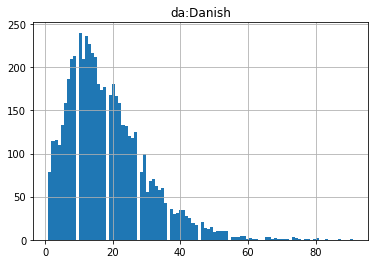

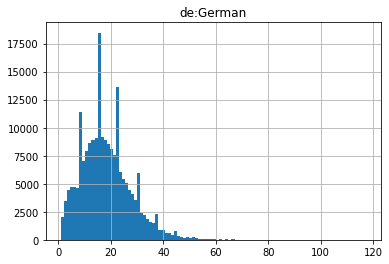

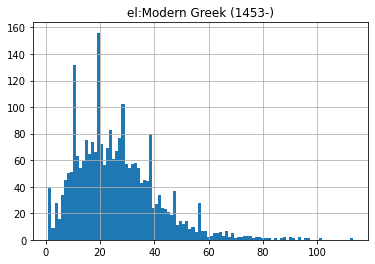

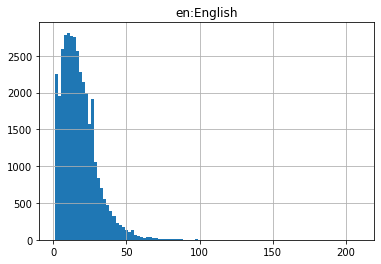

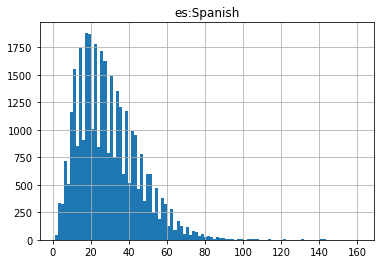

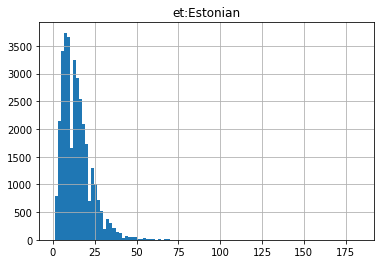

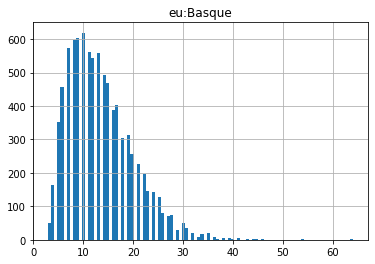

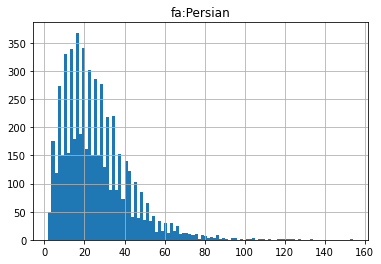

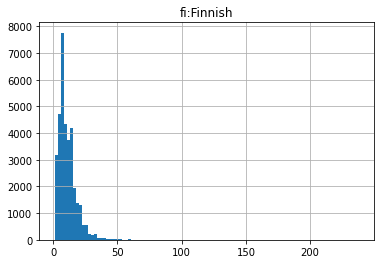

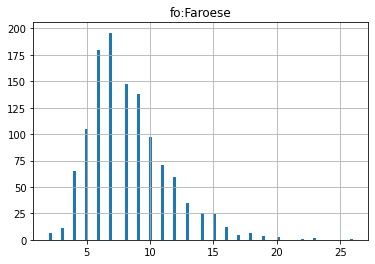

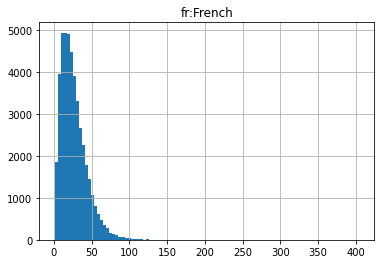

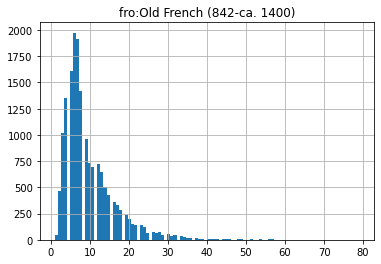

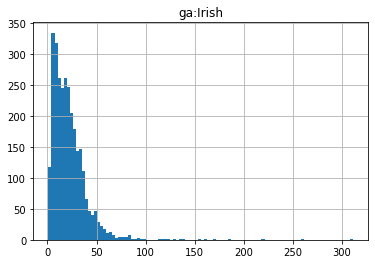

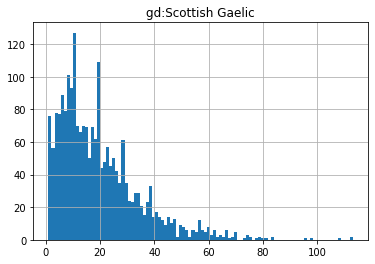

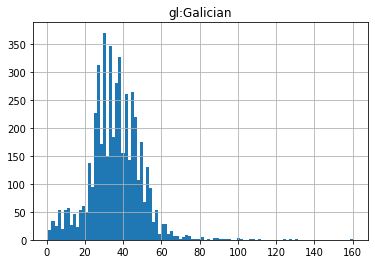

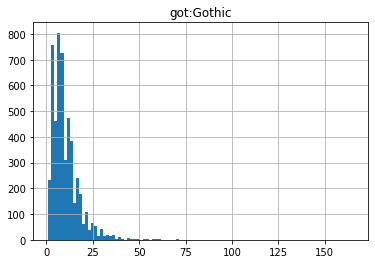

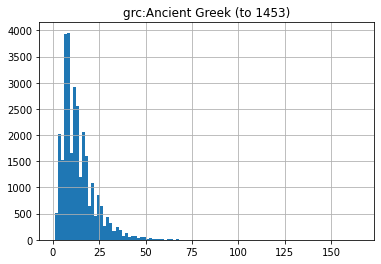

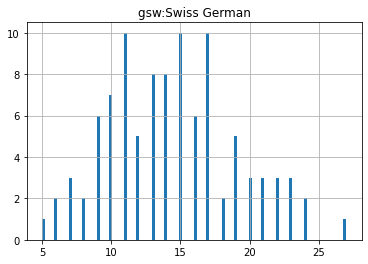

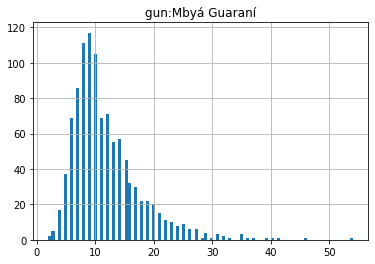

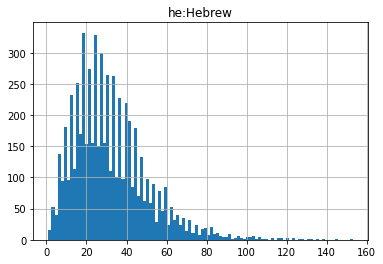

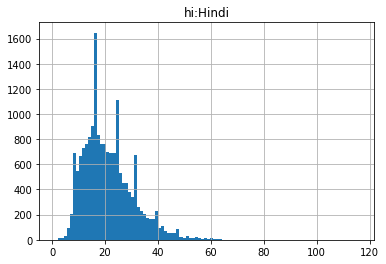

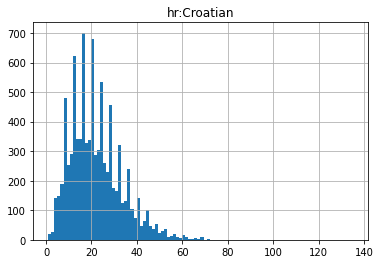

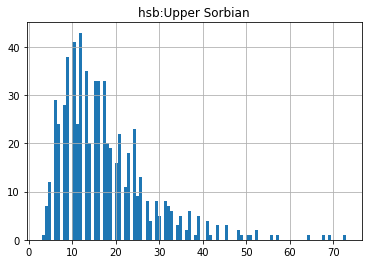

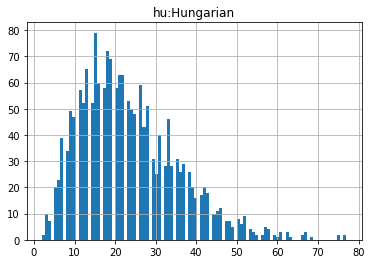

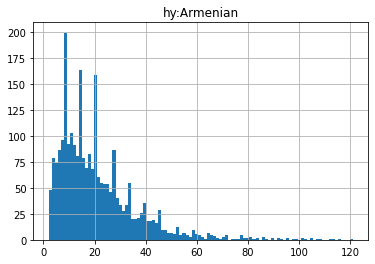

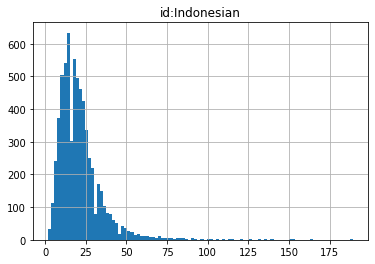

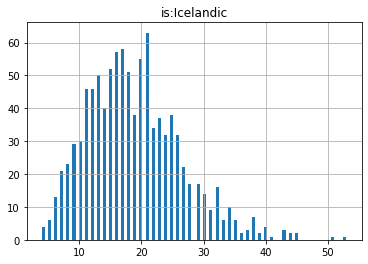

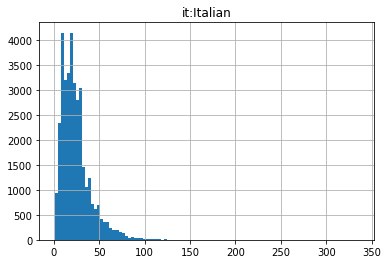

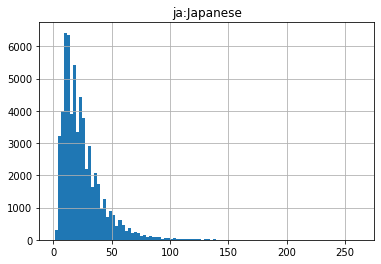

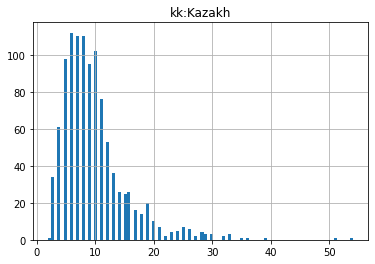

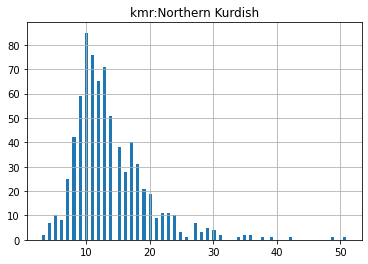

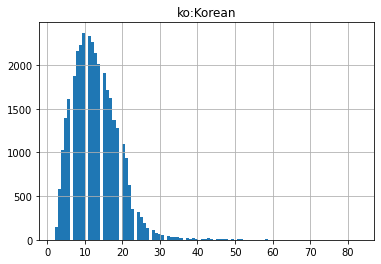

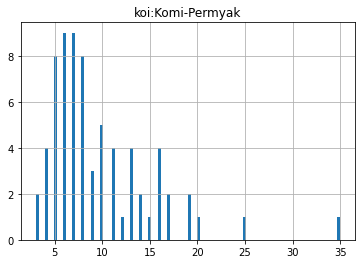

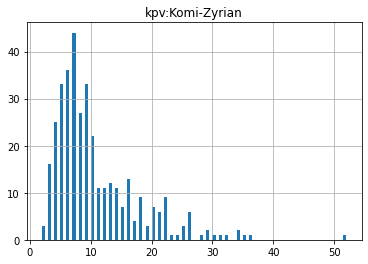

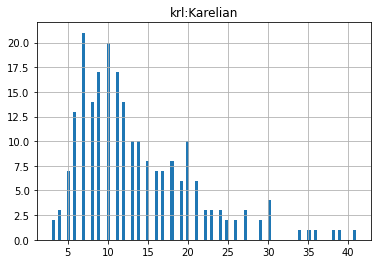

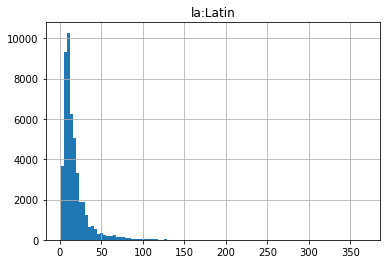

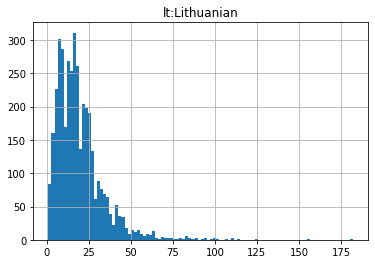

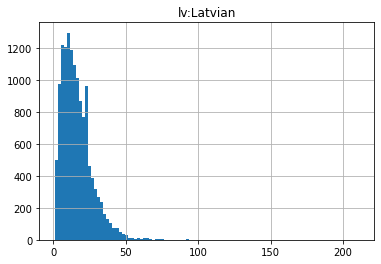

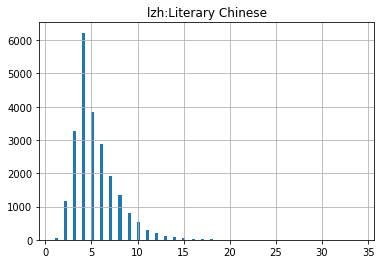

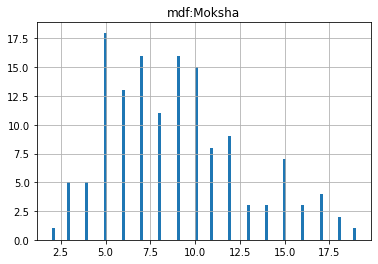

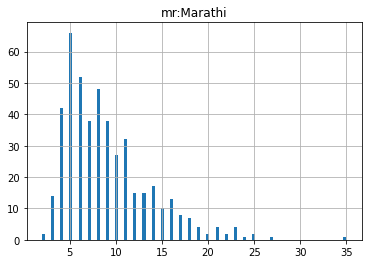

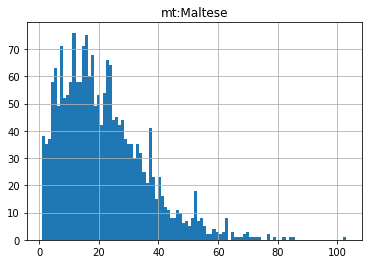

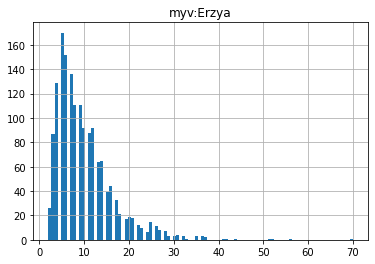

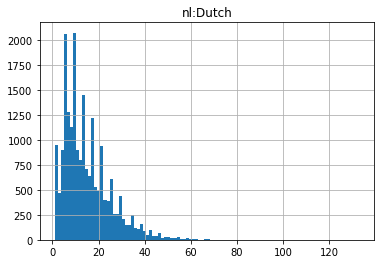

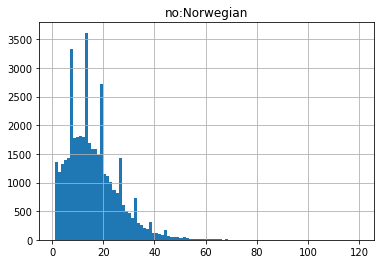

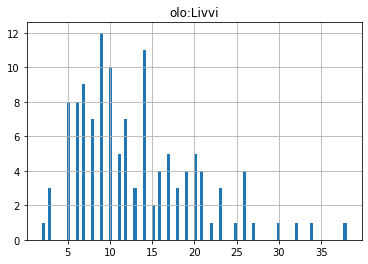

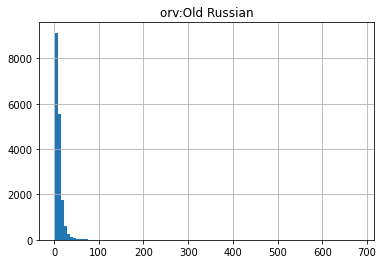

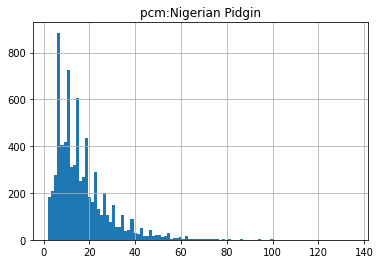

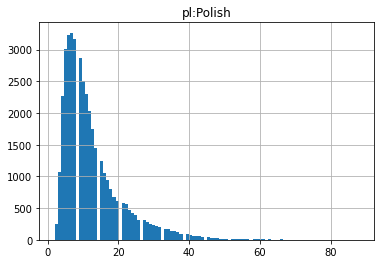

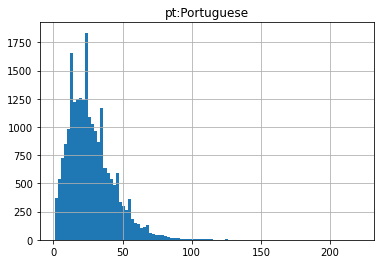

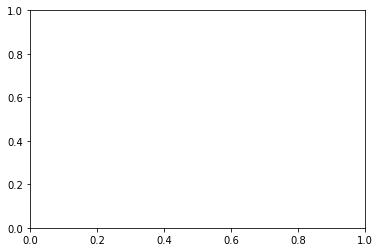

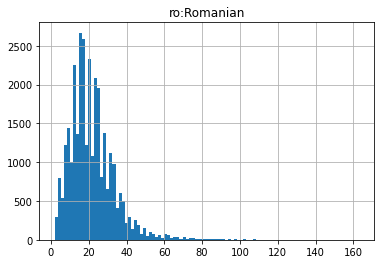

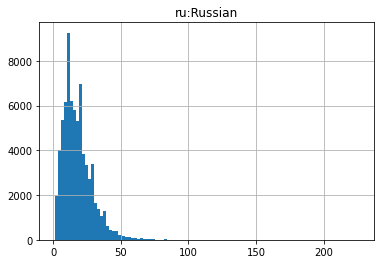

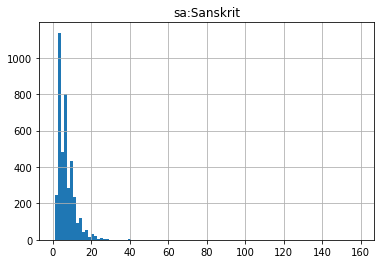

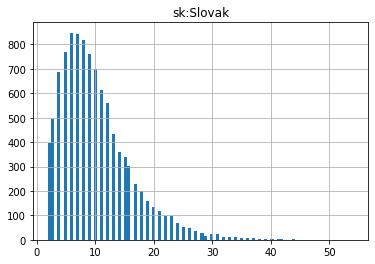

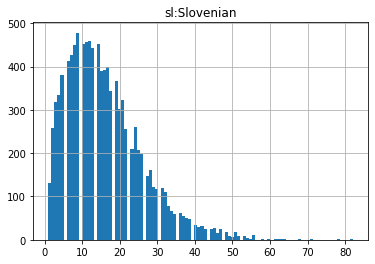

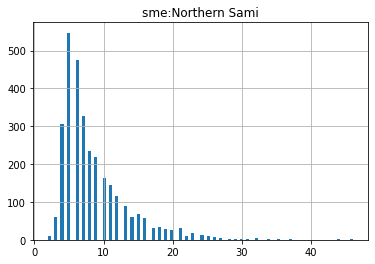

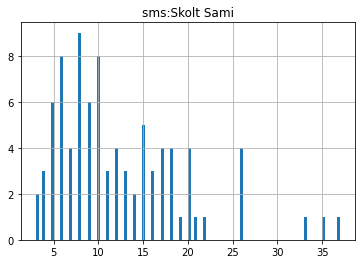

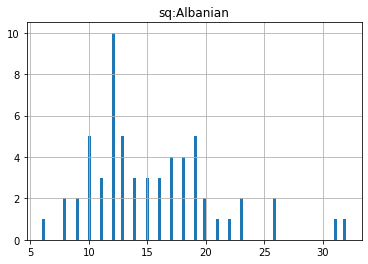

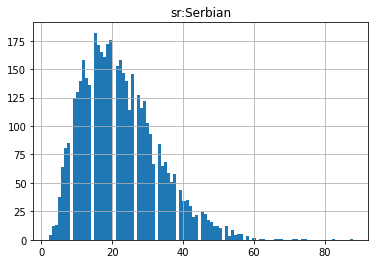

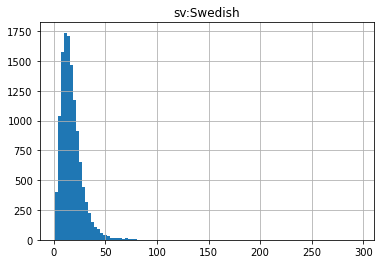

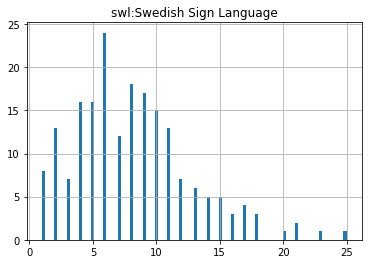

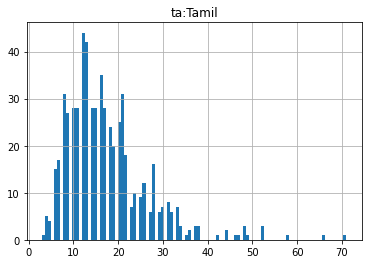

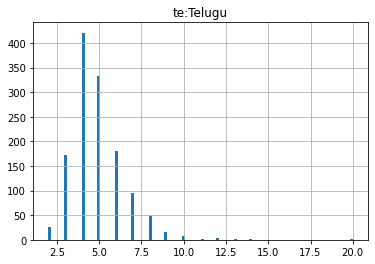

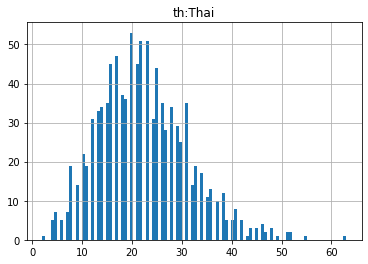

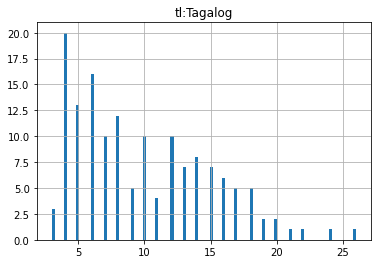

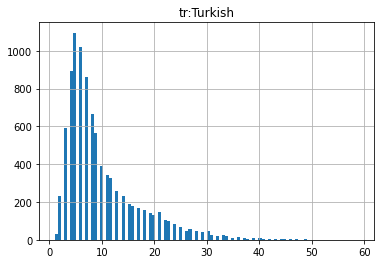

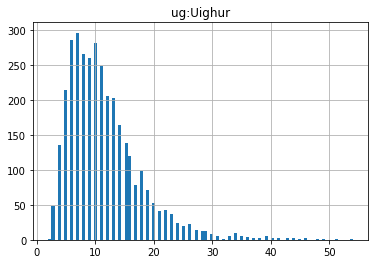

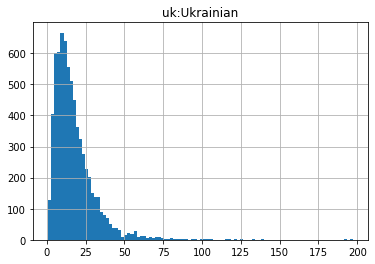

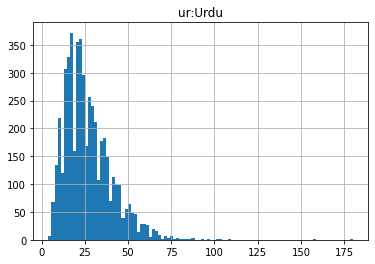

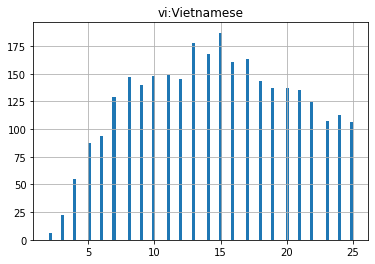

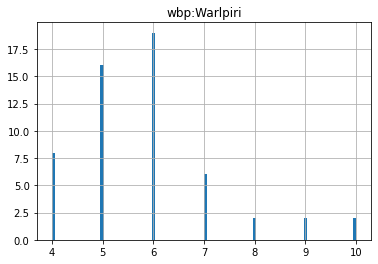

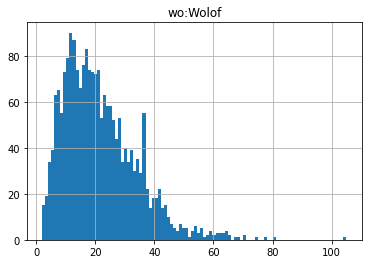

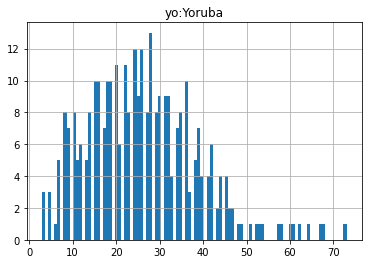

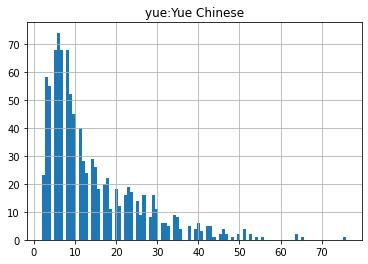

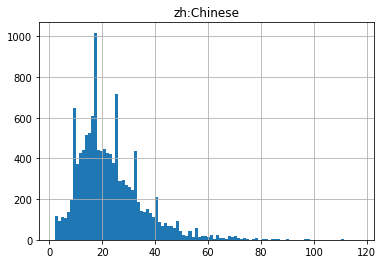

In [44]:
for lang in langs:
    try:
        fig, ax = plt.subplots()
        dest_lang = languages.get(alpha_2=lang) if len(lang) == 2 else languages.get(alpha_3=lang)
        dest_lang = dest_lang.name
        ax.set_title(lang +":" +dest_lang )
        df_deprel.loc[df_deprel['lang'] == lang]['deprel_len'].hist(bins=100, ax=ax, label=lang)
    except Exception as e:
        print("Error processing {} with Exception {}".format(lang, e))
        pass

## Character length analysis and histogram plot

In [45]:
df_txt.describe()

,text_len
count,1.212400e+06
mean,9.603918e+01
std,7.157843e+01
min,1.000000e+00
25%,4.400000e+01
50%,8.100000e+01
75%,1.310000e+02
max,3.737000e+03


Checking the values we can see, even though we have a  max of 3471 characters, if we want to see how much of the spectrum we capture is as follows (if it were a normal distribution which I don't want to test yet but it should work well enough):

| char_len | mean+X*std | % captured |
|:--------:|:----------:|:----------:|
|    90    |            |     50%    |
|    138   |            |     75%    |
|    173   |  103+1*70  |    84.2%   |
|    243   |  103+2*70  |    98.8%   |
|    313   |  103+3*70  |    99.9%   |

So going for a maximum sequence length of at least 313 should capture most of the sequences in the training and testing datasets (and as they should also be significant of each language ... it should be enough). This is done for each language later in this notebook.

In [46]:
langs

['af',
 'aii',
 'akk',
 'am',
 'ar',
 'be',
 'bg',
 'bho',
 'bm',
 'br',
 'bxr',
 'ca',
 'cop',
 'cs',
 'cu',
 'cy',
 'da',
 'de',
 'el',
 'en',
 'es',
 'et',
 'eu',
 'fa',
 'fi',
 'fo',
 'fr',
 'fro',
 'ga',
 'gd',
 'gl',
 'got',
 'grc',
 'gsw',
 'gun',
 'he',
 'hi',
 'hr',
 'hsb',
 'hu',
 'hy',
 'id',
 'is',
 'it',
 'ja',
 'kk',
 'kmr',
 'ko',
 'koi',
 'kpv',
 'krl',
 'la',
 'lt',
 'lv',
 'lzh',
 'mdf',
 'mr',
 'mt',
 'myv',
 'nl',
 'no',
 'olo',
 'orv',
 'pcm',
 'pl',
 'pt',
 'qhe',
 'ro',
 'ru',
 'sa',
 'sk',
 'sl',
 'sme',
 'sms',
 'sq',
 'sr',
 'sv',
 'swl',
 'ta',
 'te',
 'th',
 'tl',
 'tr',
 'ug',
 'uk',
 'ur',
 'vi',
 'wbp',
 'wo',
 'yo',
 'yue',
 'zh']

In [48]:

len_lang_list = []

_99p = []
_98p = []
_84p = []

for lang in langs:
    try:
        dest_lang = languages.get(alpha_2=lang) if len(lang) == 2 else languages.get(alpha_3=lang)
        dest_lang = dest_lang.name
        lng_txt = df_txt.loc[df_txt['lang'] == lang]
        d = lng_txt.describe()
        mean = d.loc['mean']['text_len']
        std = d.loc['std']['text_len']
        ef,ne,nn = math.ceil(mean+std), math.ceil(mean+2*std), math.ceil(mean+3*std)
        _99p.append(nn)
        _98p.append(ne)
        _84p.append(ef)
        len_lang_list.append((lang, dest_lang, ef, ne, nn))
        print(dest_lang)
        print("""
                |    {}   |  84.2%   |
                |    {}   |  98.8%   |
                |    {}   |  99.9%   |""".format(ef, ne, nn)
        )
        print(lng_txt.describe())
        print("_"*50)
    #     lng_txt.describe()
    except:
        pass

Afrikaans

                |    230   |  84.2%   |
                |    310   |  98.8%   |
                |    390   |  99.9%   |
          text_len
count  1899.000000
mean    149.538705
std      79.961305
min      20.000000
25%      93.000000
50%     133.000000
75%     188.000000
max     566.000000
__________________________________________________
Assyrian Neo-Aramaic

                |    72   |  84.2%   |
                |    101   |  98.8%   |
                |    130   |  99.9%   |
         text_len
count   57.000000
mean    42.789474
std     29.017690
min     12.000000
25%     24.000000
50%     36.000000
75%     49.000000
max    203.000000
__________________________________________________
Akkadian

                |    257   |  84.2%   |
                |    375   |  98.8%   |
                |    493   |  99.9%   |
         text_len
count  101.000000
mean   139.000000
std    117.946937
min      4.000000
25%     68.000000
50%    103.000000
75%    183.000000
max    858.000000
_

In [49]:
max(_99p), max(_98p), max(_84p)

(524, 404, 284)

When checking individually each language, the maximum length would be much higher, this is because some languages contain longer sentences, so we have to deal with this selecting a bigger sentence length to be able to capture most of it.


The complete list of max-99%, max-98% and max-84% is sorted and printed here:

In [50]:
list(reversed(sorted(len_lang_list, key=lambda x: x[4])))

[('ar', 'Arabic', 284, 404, 524),
 ('akk', 'Akkadian', 257, 375, 493),
 ('be', 'Belarusian', 245, 354, 463),
 ('ca', 'Catalan', 253, 341, 430),
 ('hy', 'Armenian', 221, 321, 420),
 ('es', 'Spanish', 238, 324, 410),
 ('el', 'Modern Greek (1453-)', 235, 322, 410),
 ('ga', 'Irish', 207, 304, 400),
 ('lt', 'Lithuanian', 214, 306, 398),
 ('hu', 'Hungarian', 232, 313, 394),
 ('af', 'Afrikaans', 230, 310, 390),
 ('la', 'Latin', 197, 292, 387),
 ('id', 'Indonesian', 212, 295, 378),
 ('it', 'Italian', 202, 284, 366),
 ('fa', 'Persian', 198, 278, 357),
 ('gl', 'Galician', 231, 293, 354),
 ('pt', 'Portuguese', 199, 274, 349),
 ('mt', 'Maltese', 193, 270, 348),
 ('uk', 'Ukrainian', 177, 258, 339),
 ('hr', 'Croatian', 199, 268, 338),
 ('gd', 'Scottish Gaelic', 178, 257, 335),
 ('sr', 'Serbian', 192, 256, 320),
 ('cs', 'Czech', 173, 246, 318),
 ('ur', 'Urdu', 185, 250, 314),
 ('ru', 'Russian', 172, 241, 309),
 ('de', 'German', 183, 246, 309),
 ('ro', 'Romanian', 171, 234, 298),
 ('lv', 'Latvian', 16

<ipython-input-51-de110e1cccac>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


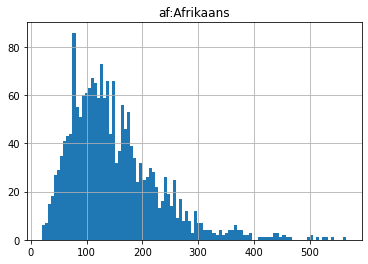

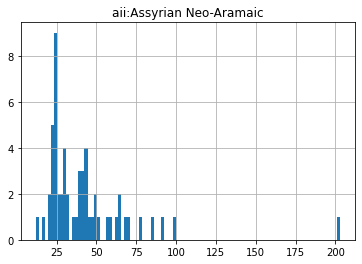

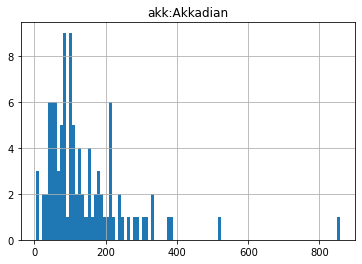

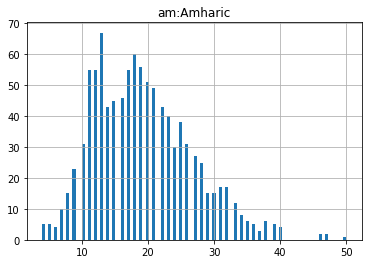

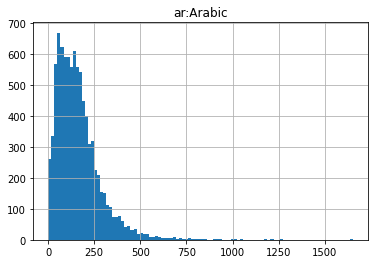

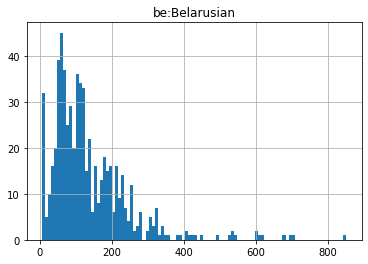

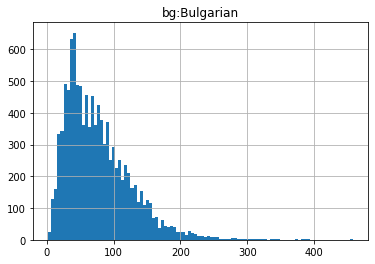

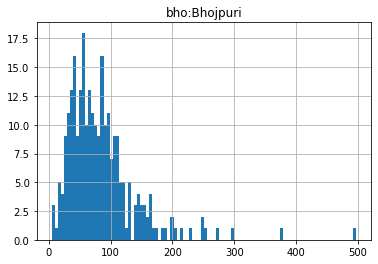

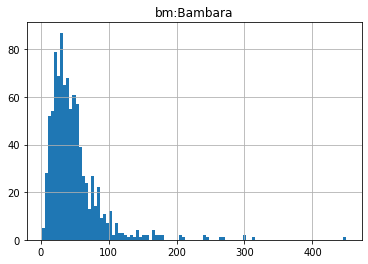

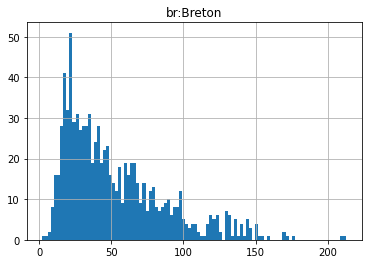

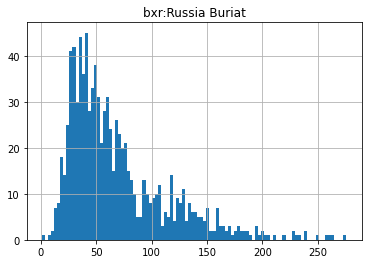

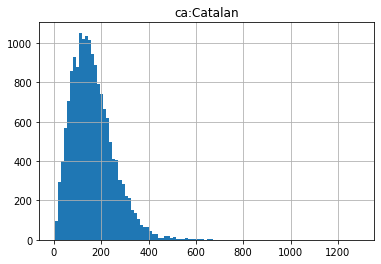

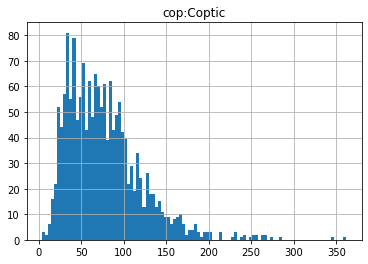

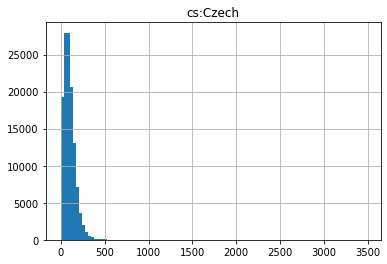

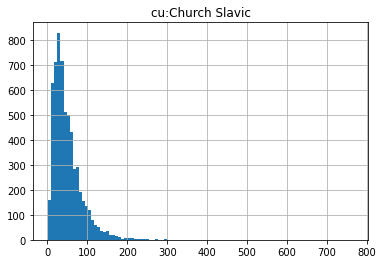

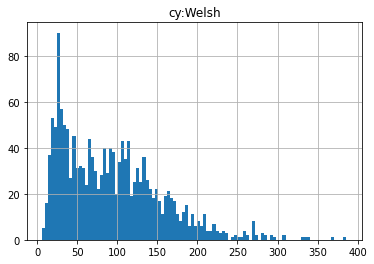

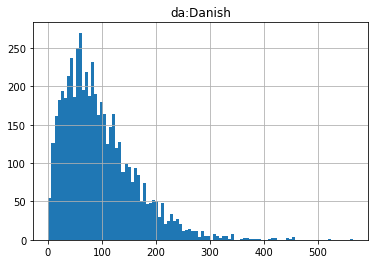

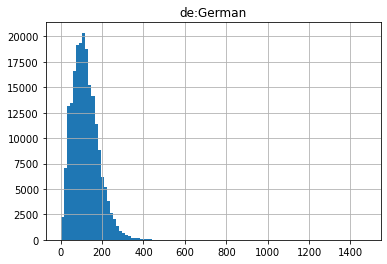

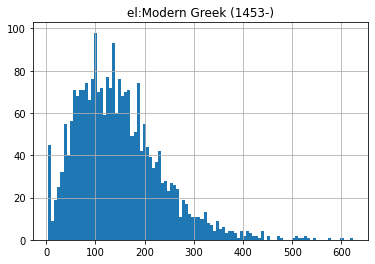

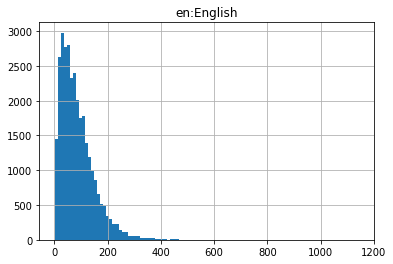

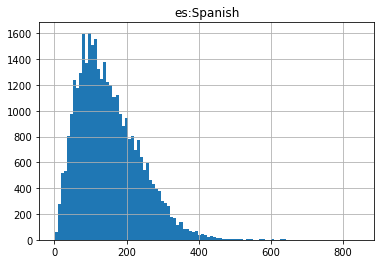

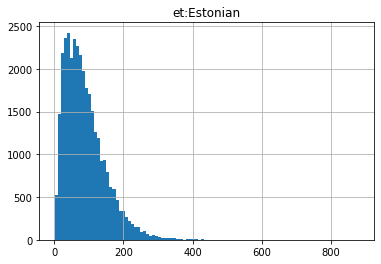

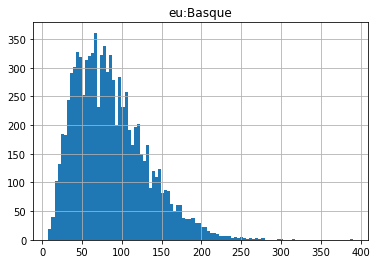

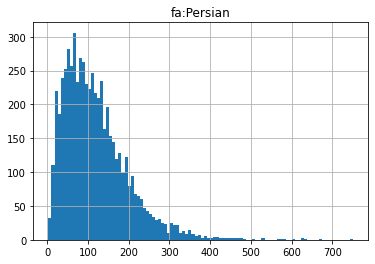

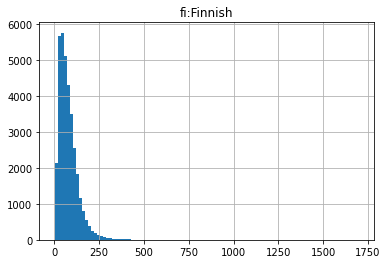

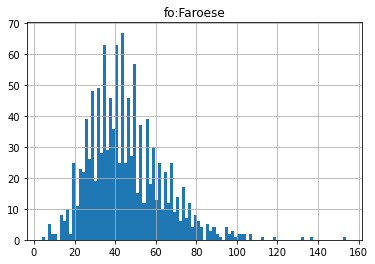

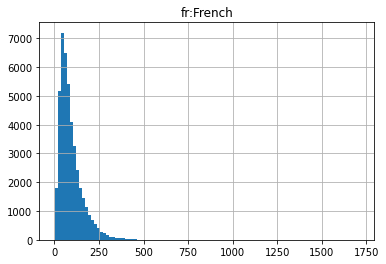

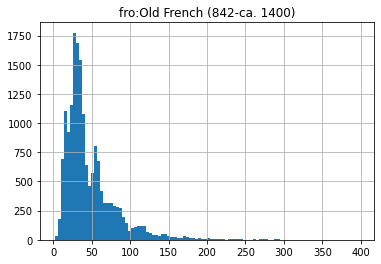

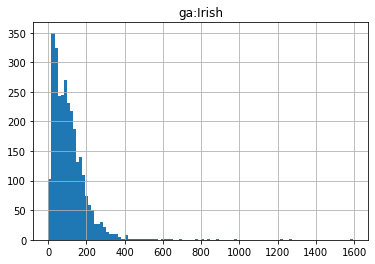

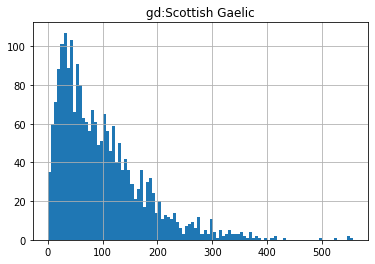

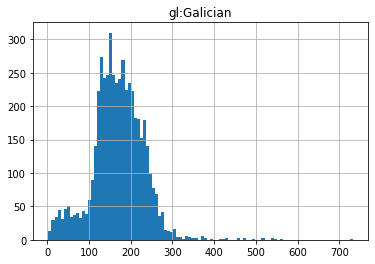

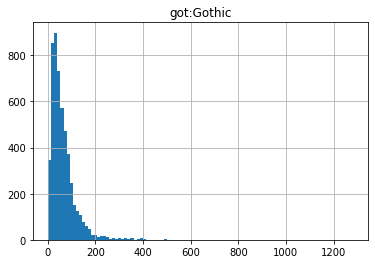

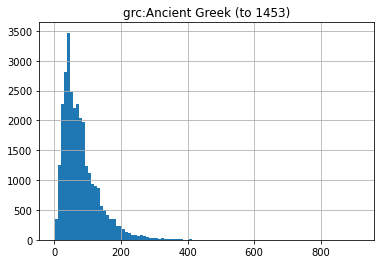

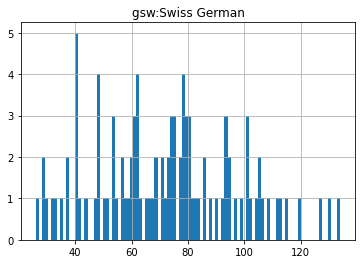

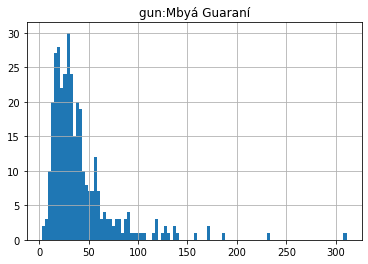

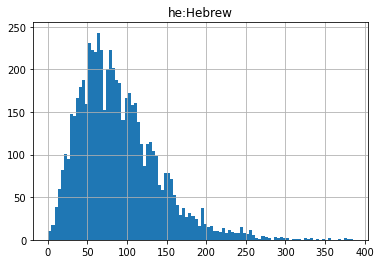

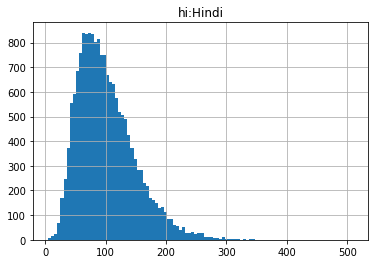

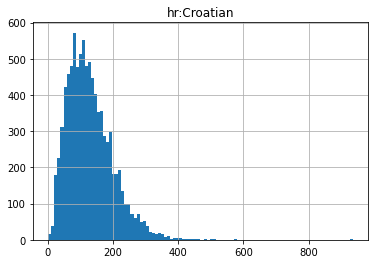

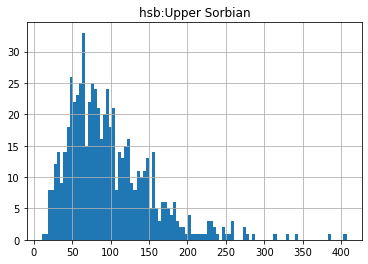

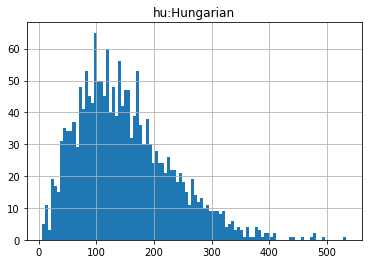

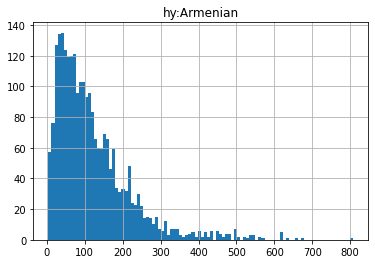

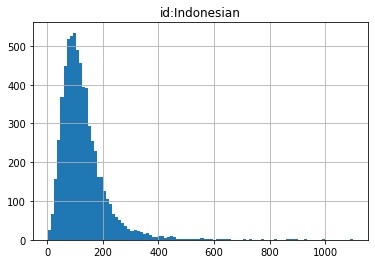

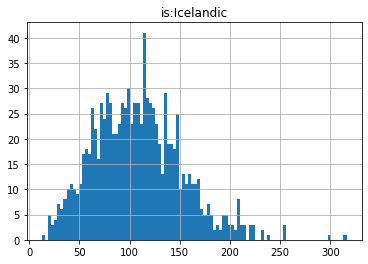

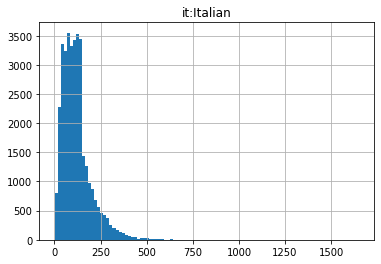

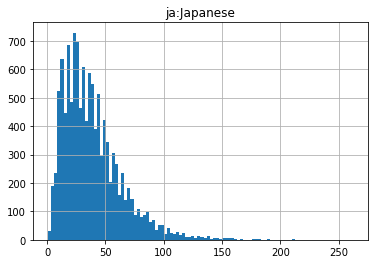

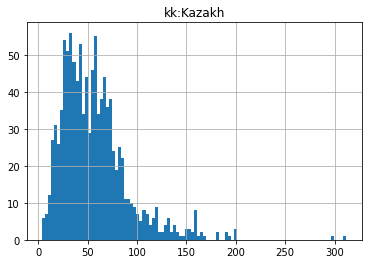

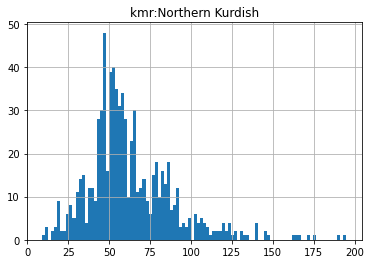

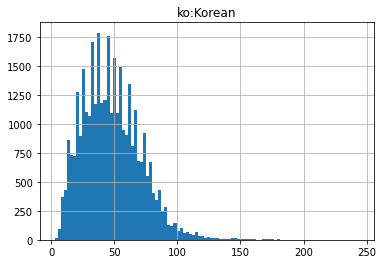

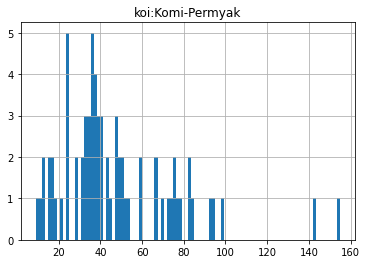

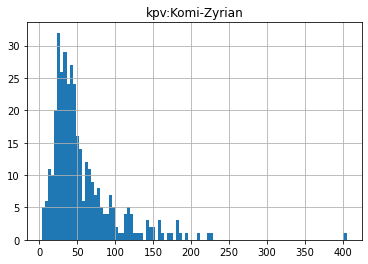

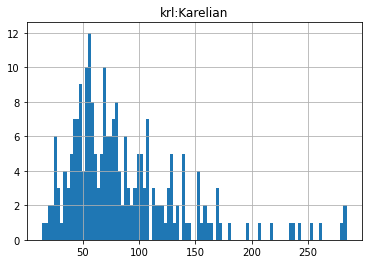

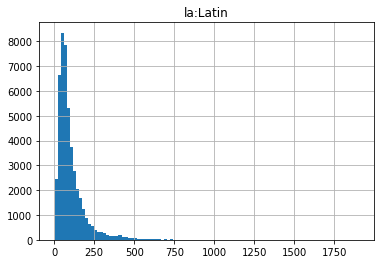

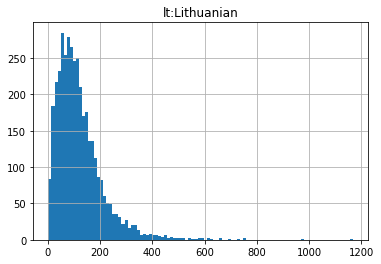

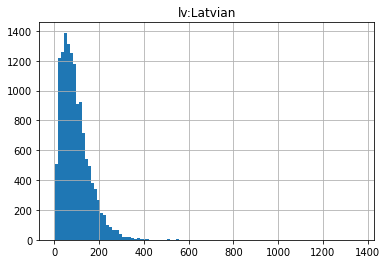

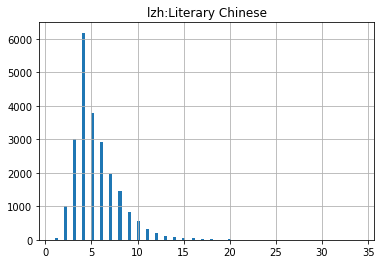

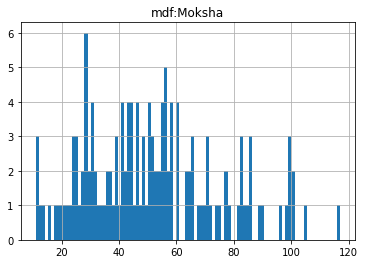

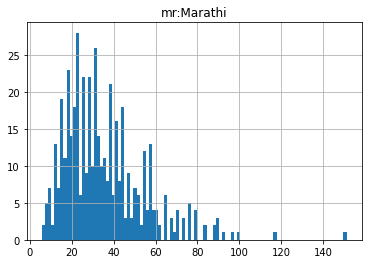

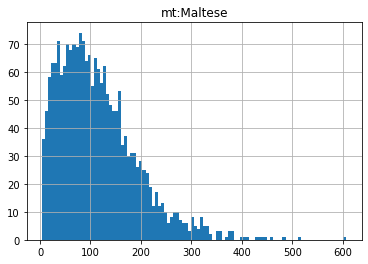

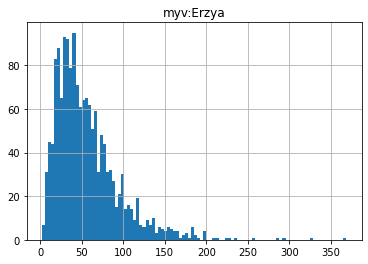

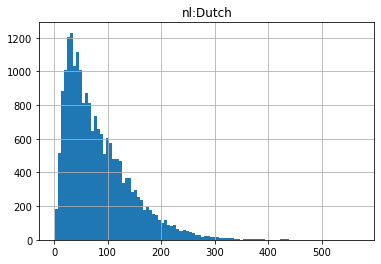

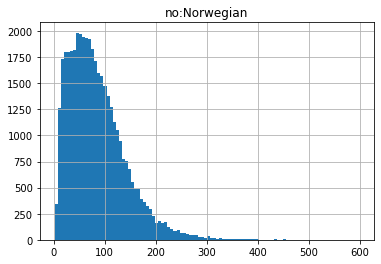

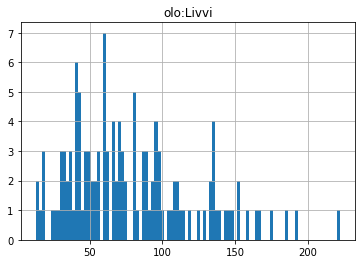

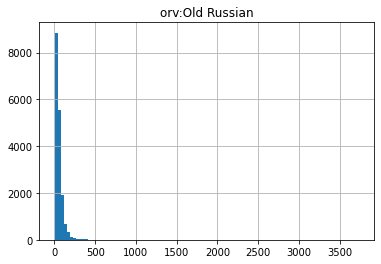

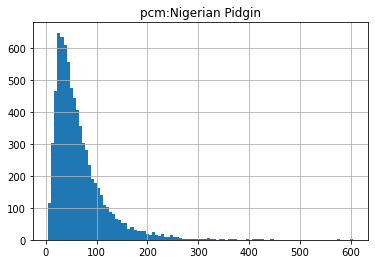

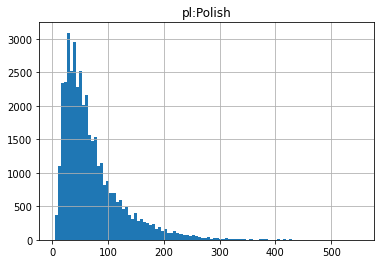

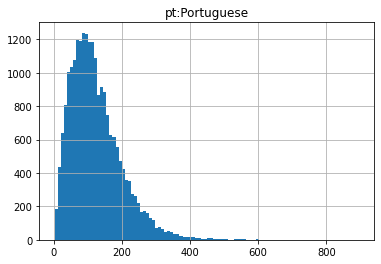

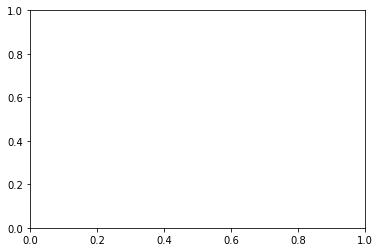

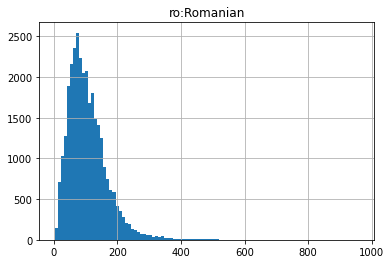

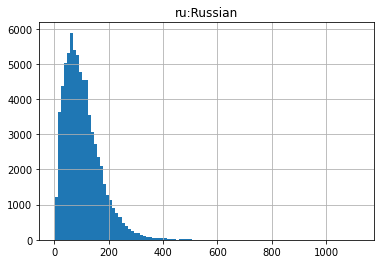

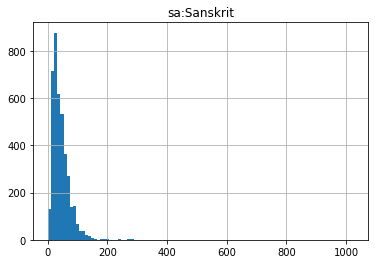

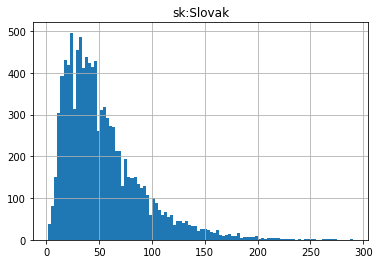

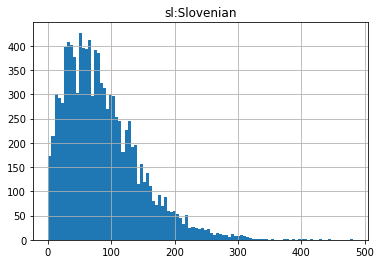

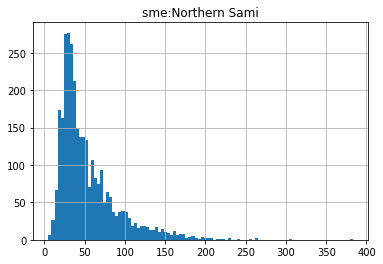

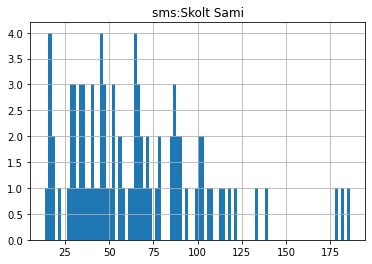

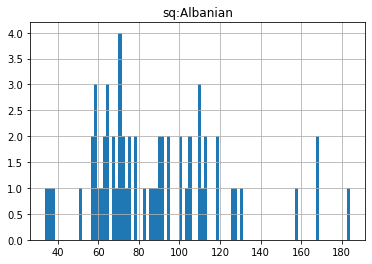

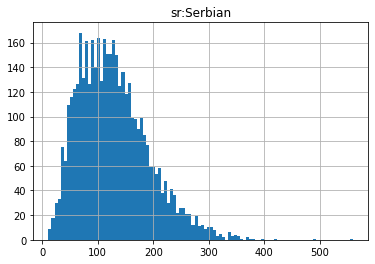

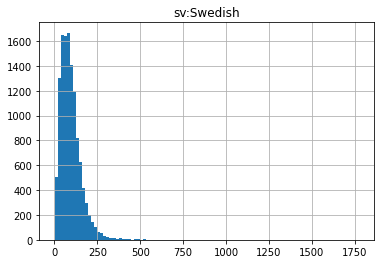

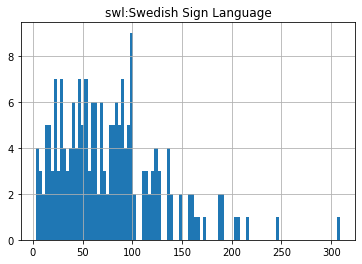

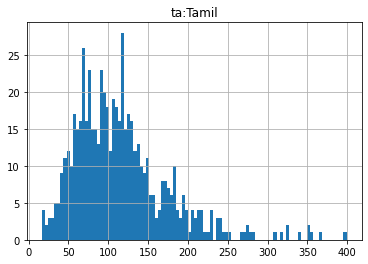

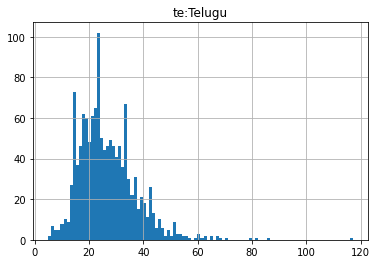

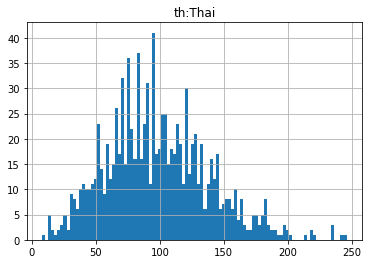

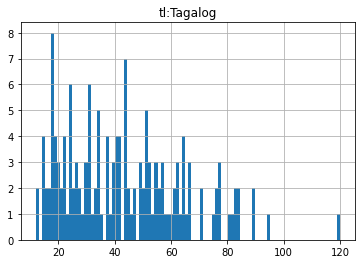

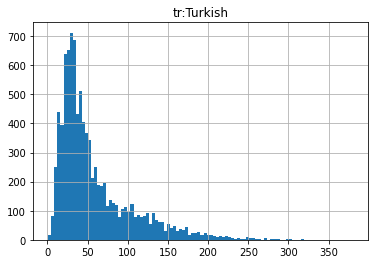

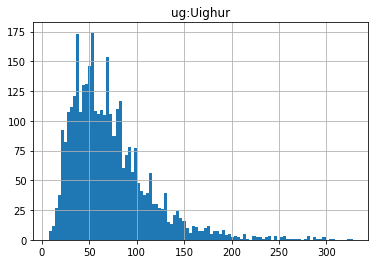

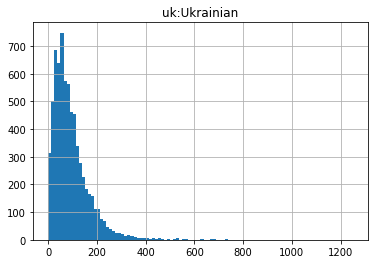

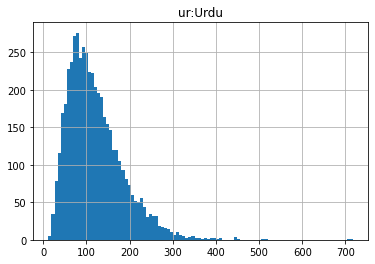

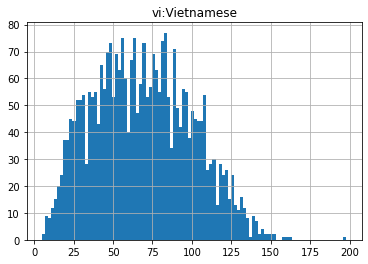

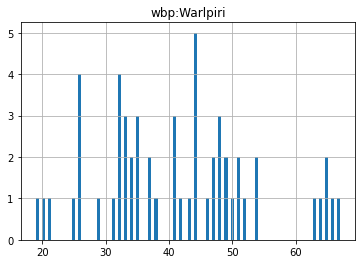

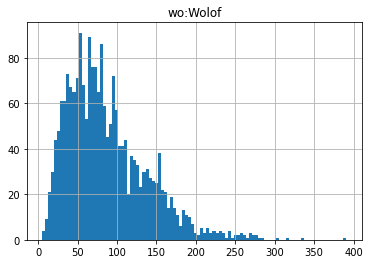

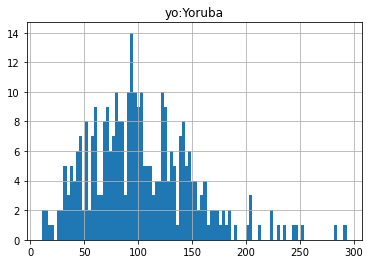

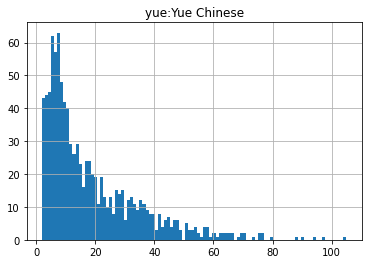

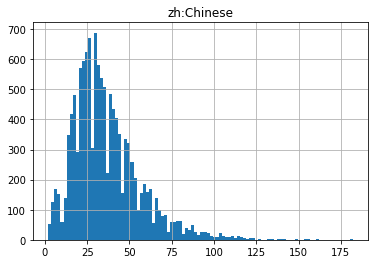

In [51]:
for lang in langs:
    try:
        fig, ax = plt.subplots()
        dest_lang = languages.get(alpha_2=lang) if len(lang) == 2 else languages.get(alpha_3=lang)
        dest_lang = dest_lang.name
        ax.set_title(lang +":" +dest_lang )
        df_txt.loc[df_txt['lang'] == lang]['text_len'].hist(bins=100, ax=ax, label=lang)
    except:
        pass